# Lark Health App Diabetes Prevention Program Insights
### Capstone 2
__EDA - Exploratory data analysis__

Data science process: <br>
Problem identification > Data wrangling > __EDA__ >

***Significance*** 
1. Users in the Lark Diabetes Prevention Program (DPP) are able to interact with the Lark app in many ways. 
2. They may have conversations with the chatbot, log any meals they eat, log physical activities, and record their weights. 
3. The app also passively records how many minutes users are physically active, and sends notifications to the users periodically. 


***About Mission***
\
As DPP users interact with the app they are also exposed to content we call “missions”. 
A mission is a set of conversations about a single topic (e.g. ”Get Active”, ”Eat Well”, ”Manage Stress”) 
which requires at least 5 completed conversations with the app before a user can move to the next mission. 
The order of the missions is the same for all users.
A user cannot see more than one mission related conversation per day, so one cannot complete a mission in fewer than 5 days. 
Note that not all in-app conversations are about the user’s current mission.

***Objective***:
\
We are interested in understanding how our users interact with the app, why and when engagement drops off, what impact the mission feature has on engagement, and any other related insights this data might provide.
The data is stored in two MySQL tables:
1. user mission: Information about when a user started and finished a mis- sion.
2. agg info: User-daily engagement metrics. These engagement metrics are briefly described above.

In [1]:
import seaborn as sns
from datetime import datetime
from pytz import timezone

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
plt.style.use('fivethirtyeight')

In [2]:
#Imports
import pandas as pd
import numpy as np
import plotly.express as px

# Data QA/QC

In [3]:
#Initial load of files (stored locally, downloaded 9/30/2021-due 10/5/2021)
df_raw = pd.read_csv('agg_info.csv', na_values="Not Available")
display(df_raw.shape)
display(df_raw.sort_values(by="USER_ID").head(5))

(468040, 8)

,USER_ID,PST_DATE,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
337721,164106,2018-12-03,2.0,3,250.38483,90,0.0,1.0
137739,164106,2018-11-21,3.0,2,136.63333,114,1.0,1.0
137738,164106,2018-11-15,3.0,3,115.28333,98,0.0,1.0
132521,164106,2018-12-04,2.0,3,172.15000,63,0.0,1.0
265969,164106,2018-12-11,1.0,3,140.50000,100,1.0,3.0


***obervation*** we have 468040 observations with 8 features. it is pretty heavy, we need to simplify that at first to understand the data better

In [4]:
df_raw.columns
df_raw.head()
df_raw.isnull().sum()
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 468040 entries, 0 to 468039
Data columns (total 8 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   USER_ID                    468040 non-null  int64  
 1   PST_DATE                   468040 non-null  object 
 2   NUM_CONVOS                 468040 non-null  float64
 3   NUM_ALL_MEALS              468040 non-null  int64  
 4   TOTAL_ACTIVITY_MINUTES2    468040 non-null  float64
 5   NUM_ACTIVITY_MEASUREMENTS  468040 non-null  int64  
 6   NUM_WEIGHTS                468040 non-null  float64
 7   NUM_NOTIFS                 468040 non-null  float64
dtypes: float64(4), int64(3), object(1)
memory usage: 28.6+ MB


***obersvation*** no missing data, great!

In [5]:
# Convert Month into Datetime
df_raw['PST_DATE']=pd.to_datetime(df_raw['PST_DATE'])
df_raw.set_index('PST_DATE',inplace=True)
df_raw.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,4.680400e+05,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000,468040.000000
mean,1.435944e+06,1.286268,1.025720,64.223719,22.624470,0.205856,2.024250
std,6.840553e+04,1.897220,1.448358,68.212569,20.315924,0.650339,1.280762
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.422975e+06,0.000000,0.000000,15.966666,6.000000,0.000000,1.000000
50%,1.441788e+06,1.000000,0.000000,46.283333,19.000000,0.000000,2.000000
75%,1.466286e+06,2.000000,2.000000,90.150000,35.000000,0.000000,3.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000


In [6]:
df_raw.dtypes

USER_ID                        int64
NUM_CONVOS                   float64
NUM_ALL_MEALS                  int64
TOTAL_ACTIVITY_MINUTES2      float64
NUM_ACTIVITY_MEASUREMENTS      int64
NUM_WEIGHTS                  float64
NUM_NOTIFS                   float64
dtype: object

#### Re-validate column data types

In [7]:
df_raw.columns.to_series().groupby(df_raw.dtypes).groups

{int64: ['USER_ID', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS'], float64: ['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_WEIGHTS', 'NUM_NOTIFS']}

### Remove Duplicates

In [8]:
df_raw.duplicated().any()

True

In [9]:
df_users = df_raw[~df_raw.duplicated(keep='first')]
df_users.describe()

,USER_ID,NUM_CONVOS,NUM_ALL_MEALS,TOTAL_ACTIVITY_MINUTES2,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,4.295720e+05,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000,429572.000000
mean,1.436871e+06,1.397447,1.114221,69.960676,24.649442,0.223069,1.970049
std,6.811232e+04,1.939641,1.477024,68.291617,19.994660,0.674813,1.283672
min,1.641060e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.423352e+06,0.000000,0.000000,23.250000,9.000000,0.000000,1.000000
50%,1.442738e+06,1.000000,0.000000,51.983334,22.000000,0.000000,2.000000
75%,1.466834e+06,2.000000,2.000000,95.316666,36.000000,0.000000,3.000000
max,1.520428e+06,38.000000,17.000000,2245.000000,1722.000000,64.000000,7.000000


In [10]:
df_users.duplicated().any()

False

**Confirm** No duplicates

# Data Evaluation

In [11]:
df_users.columns

Index(['USER_ID', 'NUM_CONVOS', 'NUM_ALL_MEALS', 'TOTAL_ACTIVITY_MINUTES2',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS'],
      dtype='object')

<AxesSubplot:>

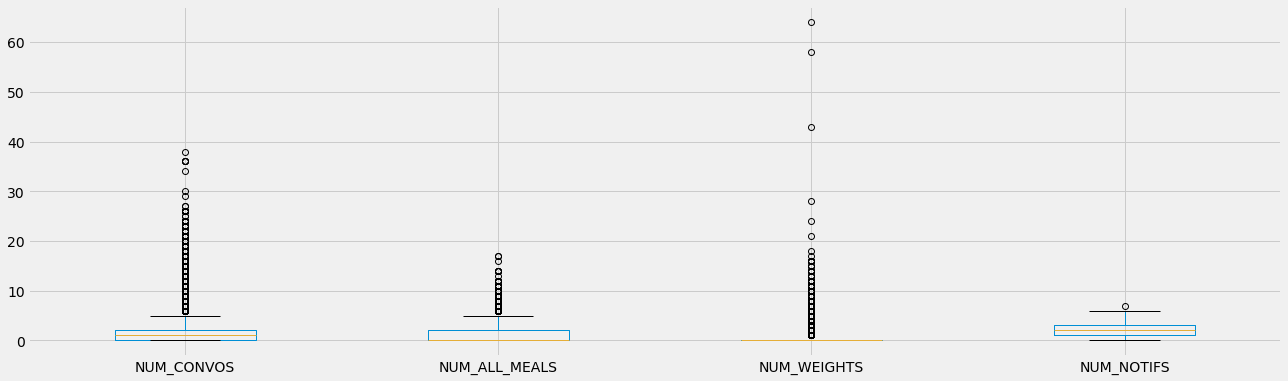

In [12]:
df_users[['NUM_CONVOS', 'NUM_ALL_MEALS',  'NUM_WEIGHTS', 'NUM_NOTIFS']].boxplot(figsize=(20,6))

<AxesSubplot:>

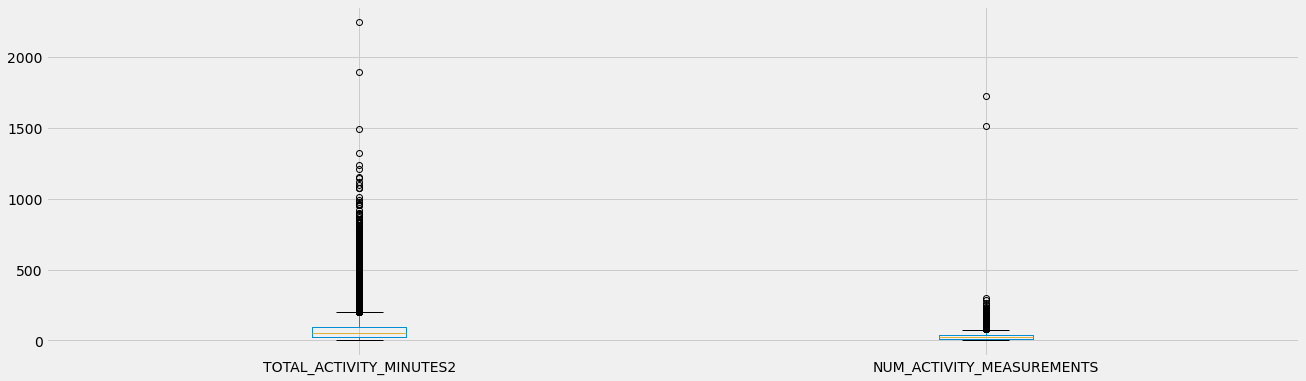

In [13]:
df_users[['TOTAL_ACTIVITY_MINUTES2','NUM_ACTIVITY_MEASUREMENTS']].boxplot(figsize=(20,6))

***Note*** Many outliers, we need to handle outliers accordingly

###  Two types of Users: 
####  create ANA feature (Active/Not Active: define as zero activities)
1. thos are physically inactive users who use app to track their meal ,weights or for social purpose
2. Users who track physical activities 
3. we can generate a flag as Active-Not-Active (ANA) Active=1 No-Active=0

In [14]:
df_inactive=df_users[(df_users['TOTAL_ACTIVITY_MINUTES2']==0) & (df_users['NUM_ACTIVITY_MEASUREMENTS']==0)]

In [16]:
df_users['ANA']=1


<ipython-input-16-2e4c2d6f7642>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users['ANA']=1


In [17]:
df_users.loc[(df_users['TOTAL_ACTIVITY_MINUTES2']==0),'ANA']=0

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [18]:
df_users.describe().iloc[:,-1:]

,ANA
count,429572.000000
mean,0.952613
std,0.212465
min,0.000000
25%,1.000000
50%,1.000000
75%,1.000000
max,1.000000


#  Univariate Analysis

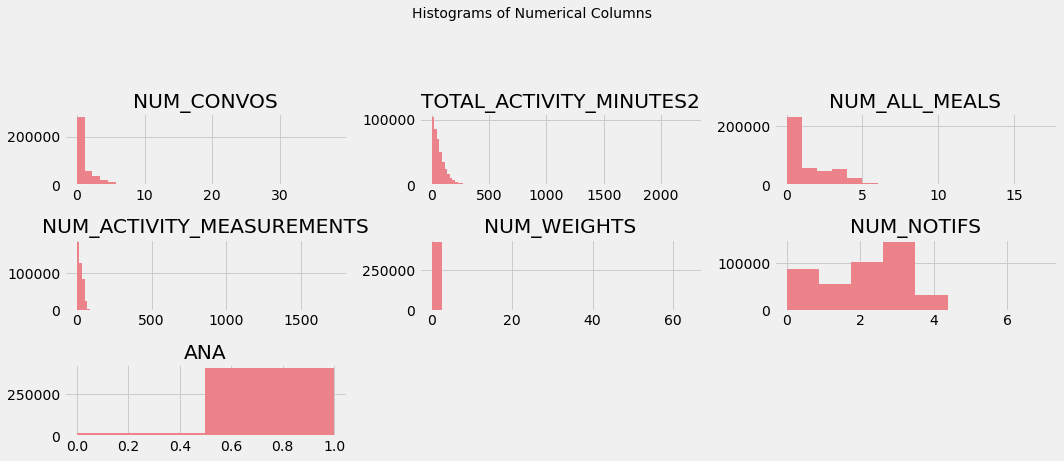

In [19]:
dataset2 = df_users[['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'ANA']]
#Histogram:
    
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns\n',horizontalalignment="center",fontstyle = "normal", fontsize = 14, fontfamily = "sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])
    
    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(dataset2.iloc[:, i], bins=vals, color = '#ec838a')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

***Note*** We need to take care of outliers

#### remove outliers

In [20]:
df_users.columns
# df_users.NUM_CONVOS.values

Index(['USER_ID', 'NUM_CONVOS', 'NUM_ALL_MEALS', 'TOTAL_ACTIVITY_MINUTES2',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'ANA'],
      dtype='object')

In [22]:
features=['NUM_CONVOS', 'NUM_ALL_MEALS', 'TOTAL_ACTIVITY_MINUTES2',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS']
for feature in features:
    upperbound=df_users[feature].quantile(0.999) # upper bound is 207
    df_users[feature] = df_users[feature].mask(df_users[feature] >upperbound, upperbound)

<ipython-input-22-66f244db786b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users[feature] = df_users[feature].mask(df_users[feature] >upperbound, upperbound)
<ipython-input-22-66f244db786b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_users[feature] = df_users[feature].mask(df_users[feature] >upperbound, upperbound)
<ipython-input-22-66f244db786b>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value ins

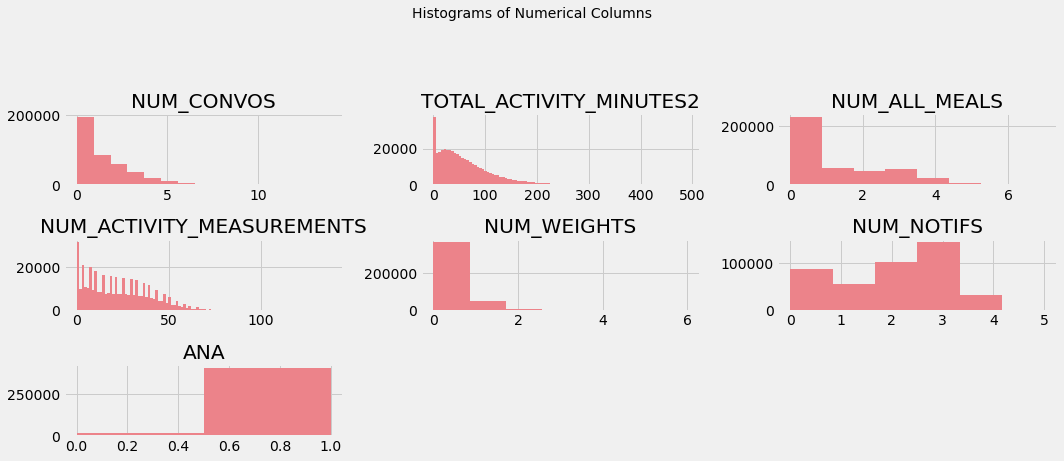

In [23]:

# def plot_hists(dataset2):    
dataset2 = df_users[['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'ANA']]
'''
plot histogram for all input columns
'''
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of Numerical Columns\n',horizontalalignment="center",fontstyle = "normal", fontsize = 14, fontfamily = "sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])

    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100

    plt.hist(dataset2.iloc[:, i], bins=vals, color = '#ec838a')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
#         return

***Note***: 
1. we are able to remove outliers from the raw data
2. Most conversation are 0-6
3. most total active minutes are 0-100 min
4. most meal measurements are 1-3 times
4. number if weights and number of activity measurements are 1 and 0-50 times
5. Only fraction of users are not active users

### cleaned data set

In [24]:
#create a cleaned dataset 
df_cleaned=df_users
df_cleaned['ANA'].value_counts()

1    409216
0     20356
Name: ANA, dtype: int64

**Note** the no-active users are about 1/20th of total users

# MultiVariate Analysis
Understand Data correlation

<ipython-input-25-346084992a54>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

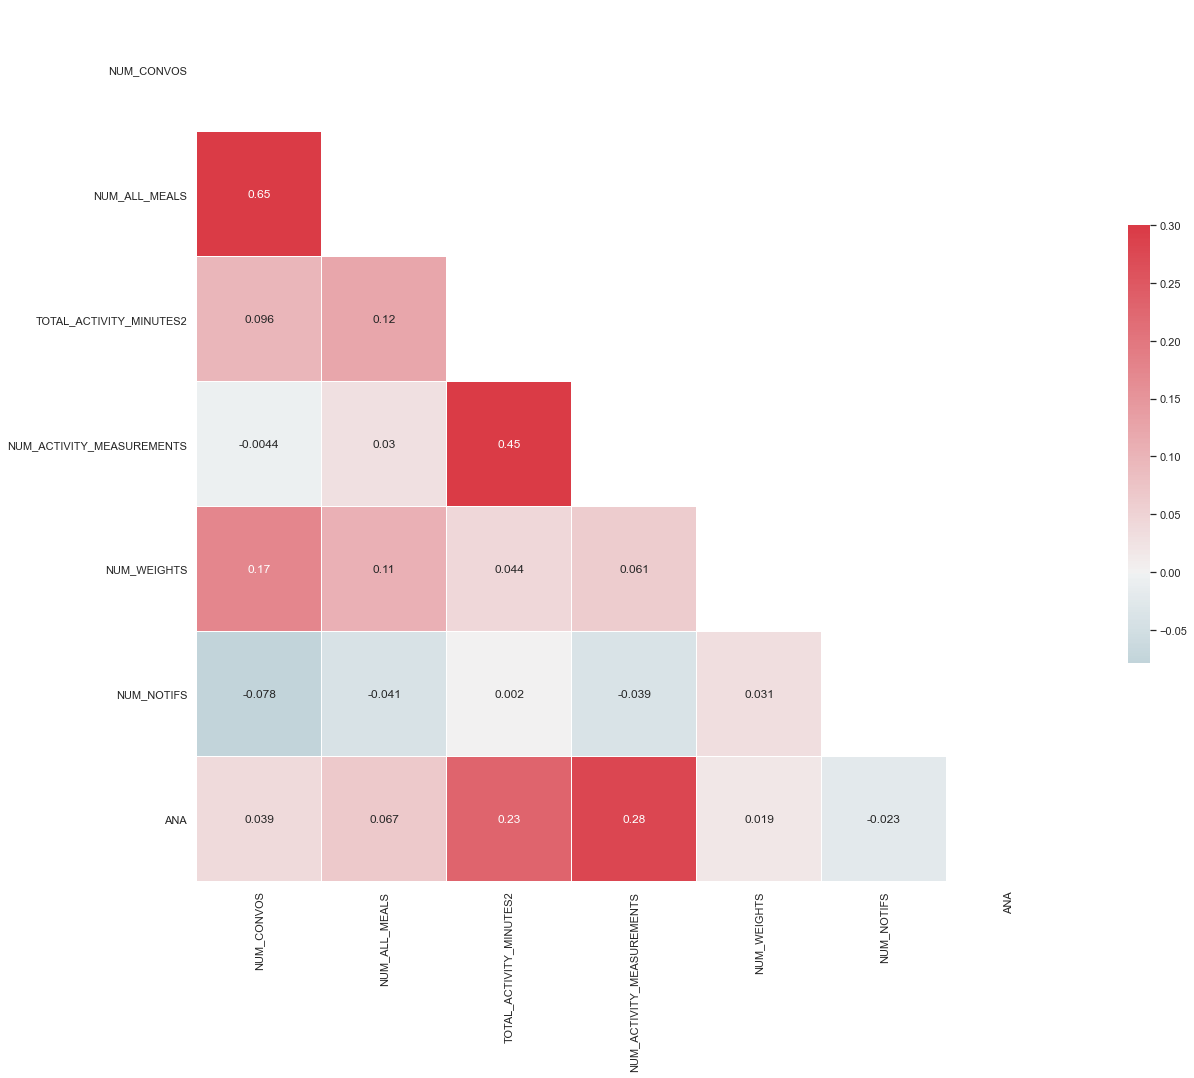

In [25]:
# df_cleaned.describe()
datacorr=df_cleaned.iloc[:, 1:]

#Set and compute the Correlation Matrix:
sns.set(style="white")
corr = datacorr.corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

**Note**
1. Strong correlation bewteen activity measurements and activity total time: "Get Active" Group
2. strong correlation between meal number and weights, "Eat Well" Group

In [26]:
#findout weekly active user resample by week and average over all features
df_W_AU = df_cleaned.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean
                                                   })

In [27]:
df_W_AU.reset_index(inplace=True)

<Figure size 864x864 with 0 Axes>

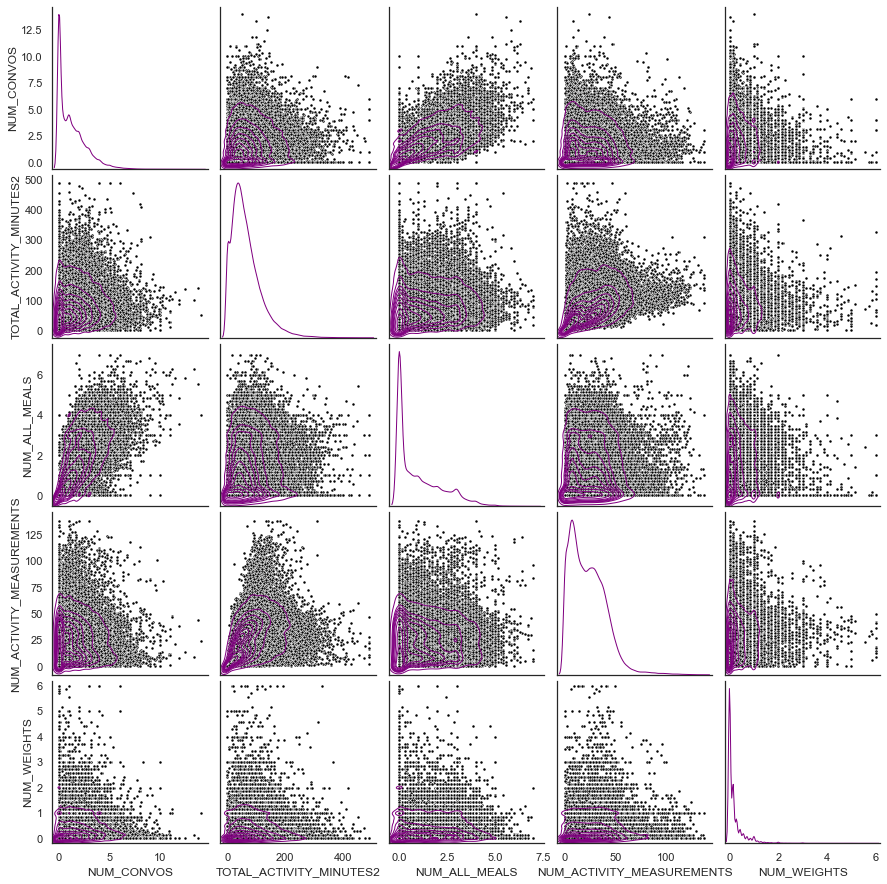

In [28]:
# pairwise plot
fig = plt.figure(figsize=(12, 12)) 
features=df_W_AU.columns.tolist()[1:-1]
g = sns.pairplot(df_W_AU[features], 
             kind='kde',
             plot_kws=dict(fill=False, color='purple', linewidths=1),
             diag_kws=dict(fill=False, color='purple', linewidth=1))

# add observation dots
g.map_offdiag(sns.scatterplot, marker='.', color='black')

**Note**:  
Num Activity Measurement has linear relationship with Activity time \
Num of Meal has high correlation with Num of Conversations

In [29]:
df_W_AU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75586 entries, 0 to 75585
Data columns (total 8 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   USER_ID                    75586 non-null  int64         
 1   PST_DATE                   75586 non-null  datetime64[ns]
 2   NUM_CONVOS                 72607 non-null  float64       
 3   TOTAL_ACTIVITY_MINUTES2    72607 non-null  float64       
 4   NUM_ALL_MEALS              72607 non-null  float64       
 5   NUM_ACTIVITY_MEASUREMENTS  72607 non-null  float64       
 6   NUM_WEIGHTS                72607 non-null  float64       
 7   NUM_NOTIFS                 72607 non-null  float64       
dtypes: datetime64[ns](1), float64(6), int64(1)
memory usage: 4.6 MB


#### did log transformation and does not make different on improving correlation of features

In [30]:
# df_W_AU.loc[df_W_AU['NUM_CONVOS']<=0]['NUM_CONVOS']=0.001
#df_name.query("UserType == 'Existing'")['PST_DATE']

<ipython-input-30-f37d4d95dd3f>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_W_AU.loc[df_W_AU['NUM_CONVOS']<=0]['NUM_CONVOS']=0.001


In [31]:
# df_W_AU_log=df_W_AU
# df_W_AU_log.dropna()
# features=df_W_AU.columns.tolist()[2:]
# for feature in features:
#     df_W_AU_log.loc[df_W_AU_log[feature]<=0][feature]=0.001
#     df_W_AU_log[feature]=df_W_AU[feature].map(np.log)

In [32]:
# df_W_AU_log.describe()

In [33]:
# # pairwise plot
# fig = plt.figure(figsize=(12, 12)) 
# features=df_W_AU.columns.tolist()[1:-1]
# g = sns.pairplot(df_W_AU_log[features], 
#              kind='kde',
#              plot_kws=dict(fill=False, color='purple', linewidths=1),
#              diag_kws=dict(fill=False, color='purple', linewidth=1))

# # add observation dots
# g.map_offdiag(sns.scatterplot, marker='.', color='black')

# Define <ins> Active Users: 
Users with high engagements weekly
#https://towardsdatascience.com/data-driven-growth-with-python-part-1-know-your-metrics-812781e66a5b
df_cleaned

In [34]:
#findout weekly active user resample by week and average over all features
df_W_AU = df_cleaned.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean
                                                   })

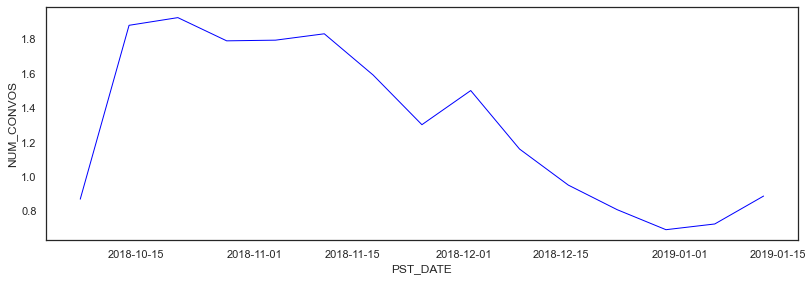

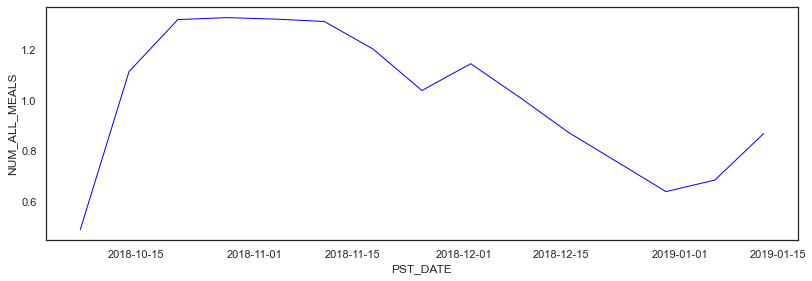

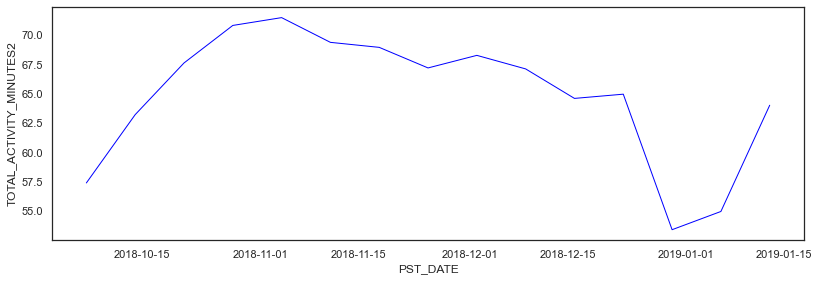

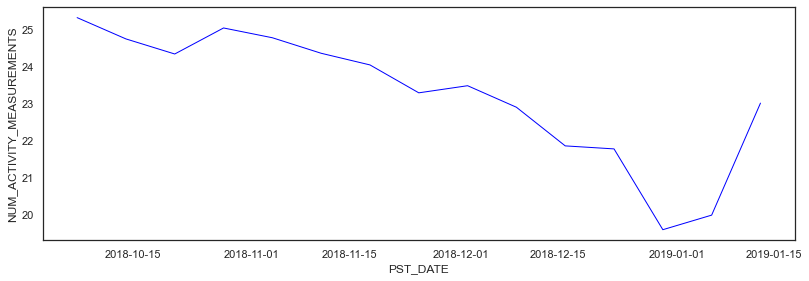

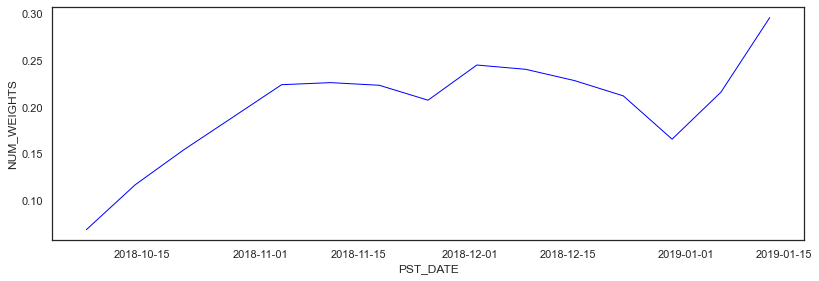

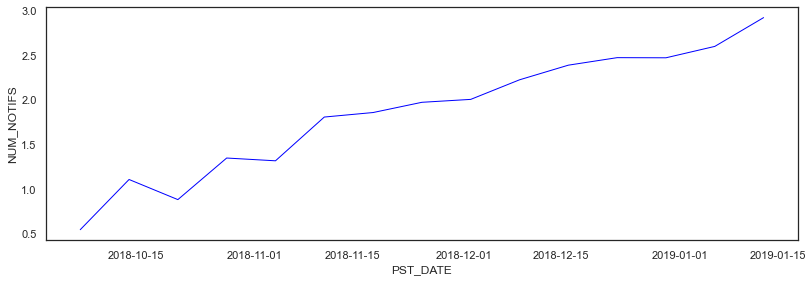

In [36]:
features=df_cleaned.columns.tolist()[1:-1]
for feature in features:
    df_W_AU_avg = df_W_AU.groupby(['PST_DATE'])[feature].mean().reset_index()
#     df_W_AU_avg
    fig = plt.figure(figsize=(12,4)) 
    sns.lineplot(x='PST_DATE', y = feature, data=df_W_AU_avg, color='blue', linewidth=1, legend=True)

### Trends of average weekly user engagement 
1. Over all decrease of engagements over holiday season and increase after new year
2. No of notification increases

### let's figure out weekly active user <ins>activity engagement rate

,PST_DATE,NUM_NOTIFS,WeeklyPctChangeNUM_NOTIFS
0,2018-10-07,0.543153,NaN
1,2018-10-14,1.105525,1.035383
2,2018-10-21,0.880111,-0.203897
3,2018-10-28,1.345896,0.529234
4,2018-11-04,1.314830,-0.023082


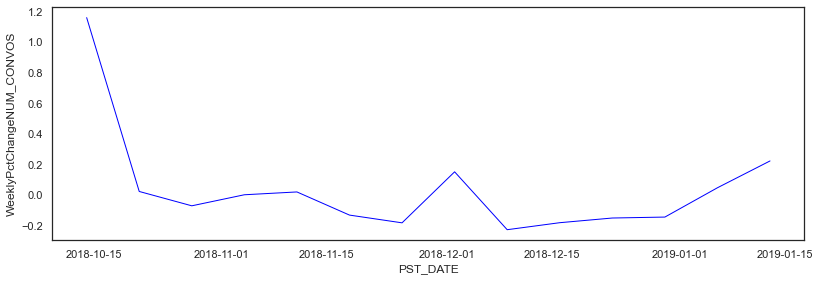

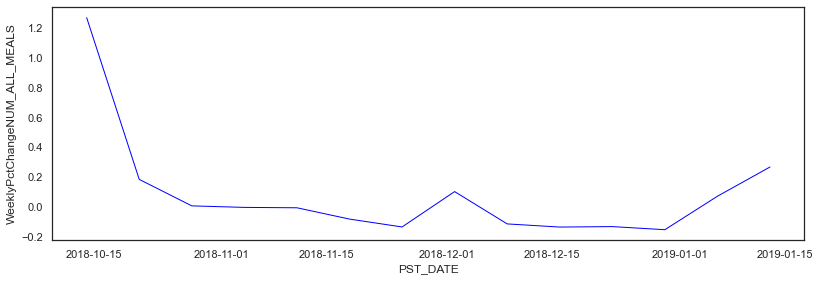

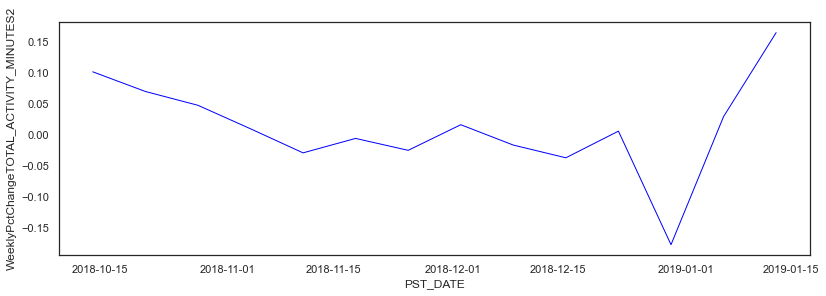

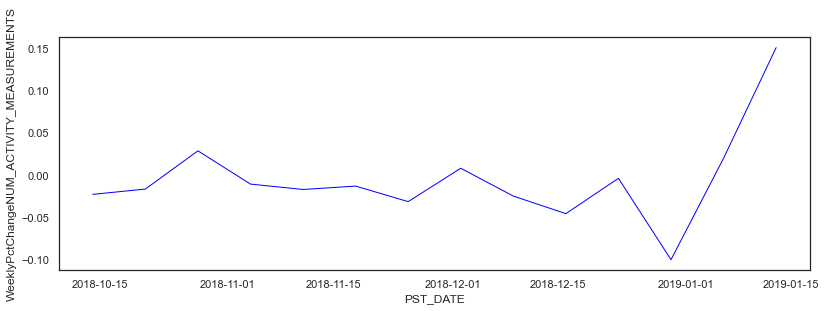

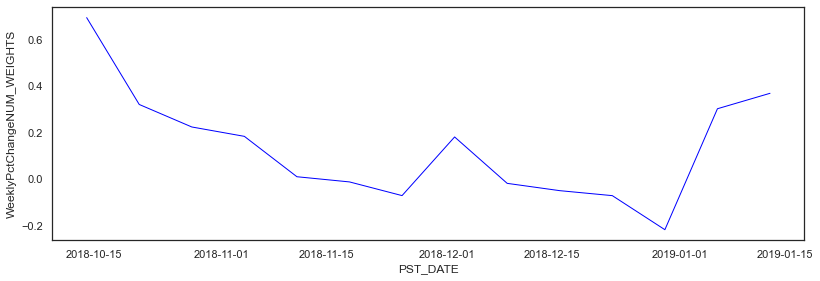

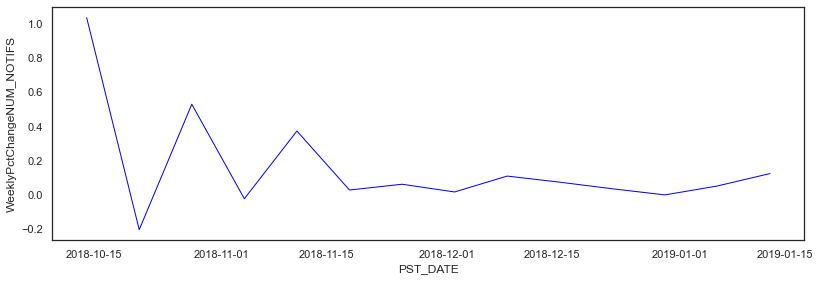

In [37]:
features=df_cleaned.columns.tolist()[1:-1]
for feature in features:
    df_W_AU_avg = df_W_AU.groupby(['PST_DATE'])[feature].mean().reset_index()
    newfeaturename='WeeklyPctChange'+feature
    df_W_AU_avg[newfeaturename] = df_W_AU_avg[feature].pct_change()
#     df_W_AU_avg
    fig = plt.figure(figsize=(12,4)) 
    sns.lineplot(x='PST_DATE', y = newfeaturename, data=df_W_AU_avg, color='blue', linewidth=1, legend=True)
    
#using pct_change() function to see monthly percentage change
df_W_AU_avg[newfeaturename] = df_W_AU_avg[feature].pct_change()

#showing first 5 rows
df_W_AU_avg.head()

#### similar conclusion: weekly change decrease towards holiday season and increase after

### Weekly Active User

In [38]:
df_cleaned.columns.tolist()[:]

['USER_ID',
 'NUM_CONVOS',
 'NUM_ALL_MEALS',
 'TOTAL_ACTIVITY_MINUTES2',
 'NUM_ACTIVITY_MEASUREMENTS',
 'NUM_WEIGHTS',
 'NUM_NOTIFS',
 'ANA']

In [39]:
#creating a new dataframe with UK customers only
#creating monthly active customers dataframe by counting unique Customer IDs
df_W_AU_UserID = df_W_AU.reset_index().groupby(['PST_DATE'])['USER_ID'].nunique()

#print the dataframe
df_W_AU_UserID=pd.DataFrame(df_W_AU_UserID)
df_W_AU_UserID.reset_index(inplace=True)

[Text(0, 0, '2018-10-07'),
 Text(1, 0, '2018-10-14'),
 Text(2, 0, '2018-10-21'),
 Text(3, 0, '2018-10-28'),
 Text(4, 0, '2018-11-04'),
 Text(5, 0, '2018-11-11'),
 Text(6, 0, '2018-11-18'),
 Text(7, 0, '2018-11-25'),
 Text(8, 0, '2018-12-02'),
 Text(9, 0, '2018-12-09'),
 Text(10, 0, '2018-12-16'),
 Text(11, 0, '2018-12-23'),
 Text(12, 0, '2018-12-30'),
 Text(13, 0, '2019-01-06'),
 Text(14, 0, '2019-01-13')]

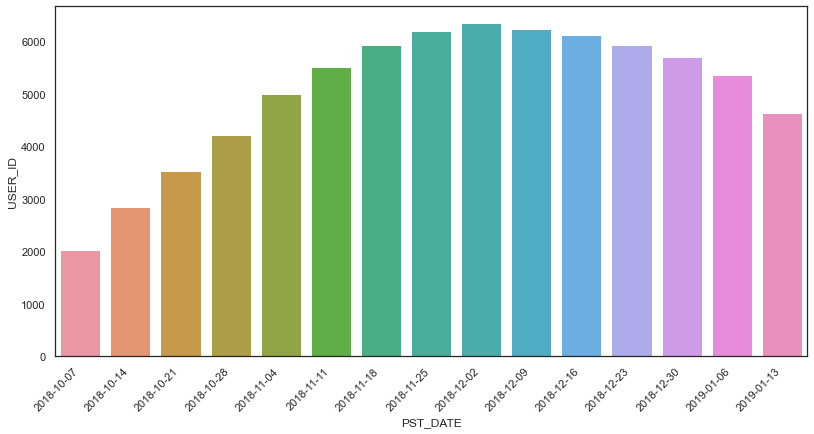

In [40]:
# PLOTTING
fig, ax = plt.subplots(figsize = (12,6))  
# plt.figure(figsize = (15,8))
sns.barplot(x = 'PST_DATE', y = 'USER_ID',data = df_W_AU_UserID)
x_dates = df_W_AU_UserID['PST_DATE'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


### Note: Active unique UserID  decreases after new year

In [41]:
#creating monthly features dataframe by counting unique Customer IDs
df_W_AU_features_sum = df_W_AU.reset_index().groupby(['PST_DATE'])[features].sum()
# tx_monthly_sales = tx_uk.groupby('InvoiceYearMonth')['Quantity'].sum().reset_index()
df_W_AU_features_sum.reset_index(inplace=True)



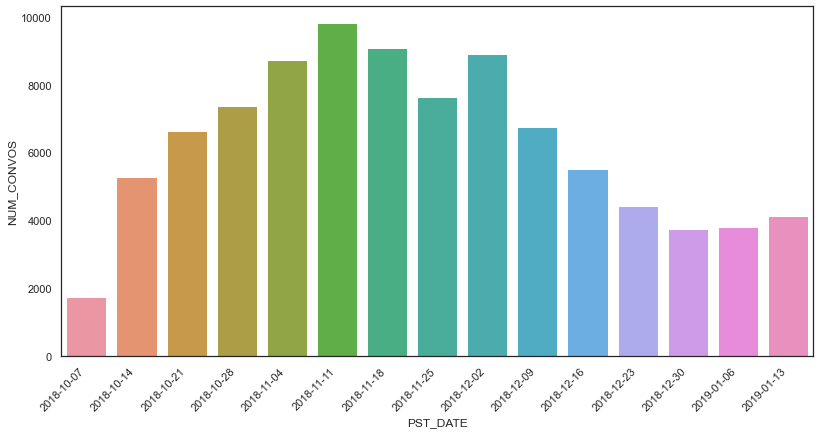

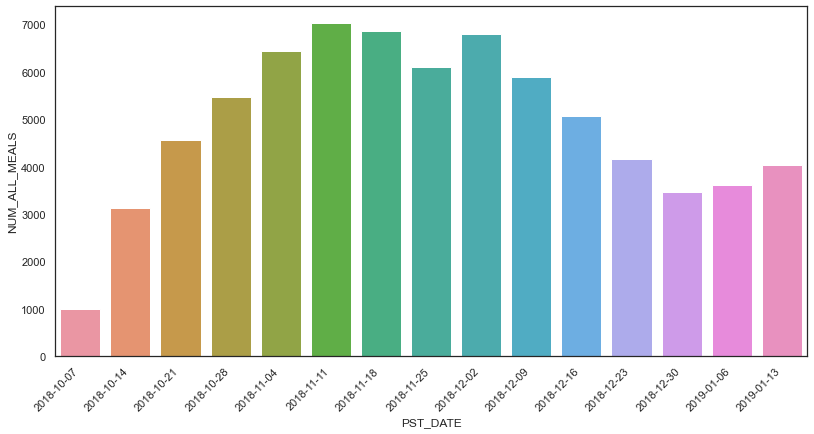

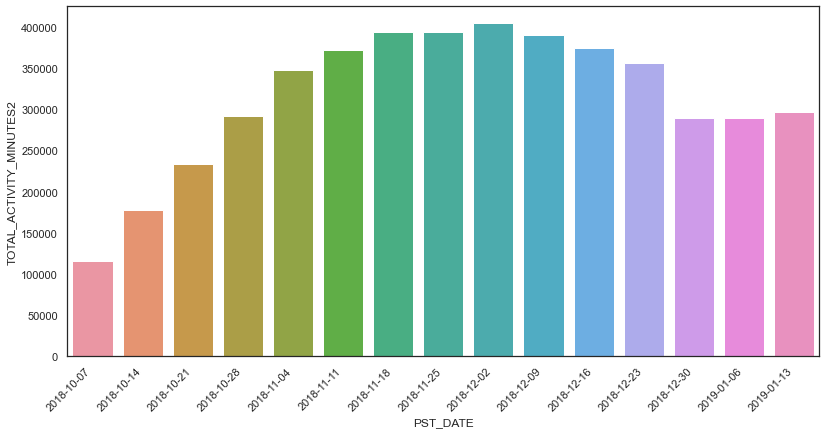

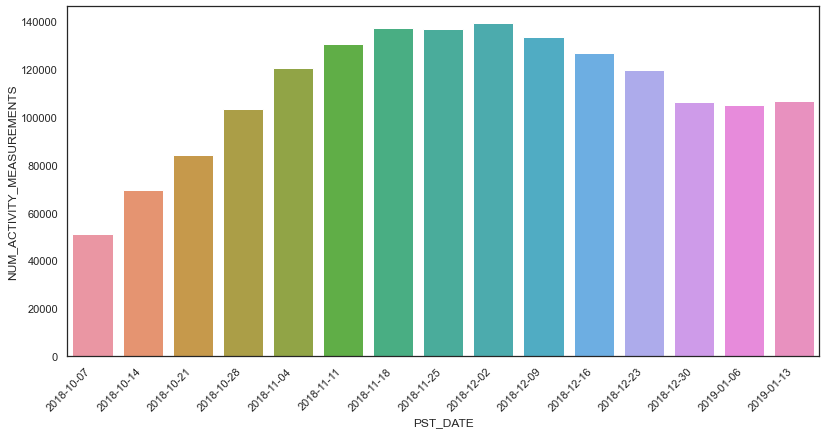

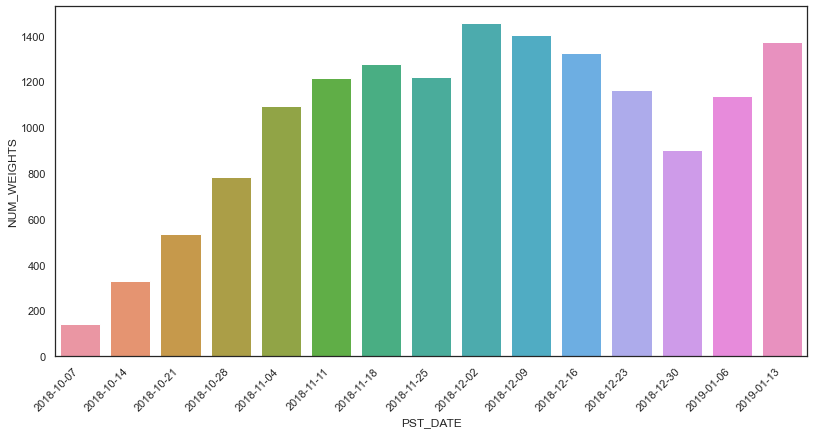

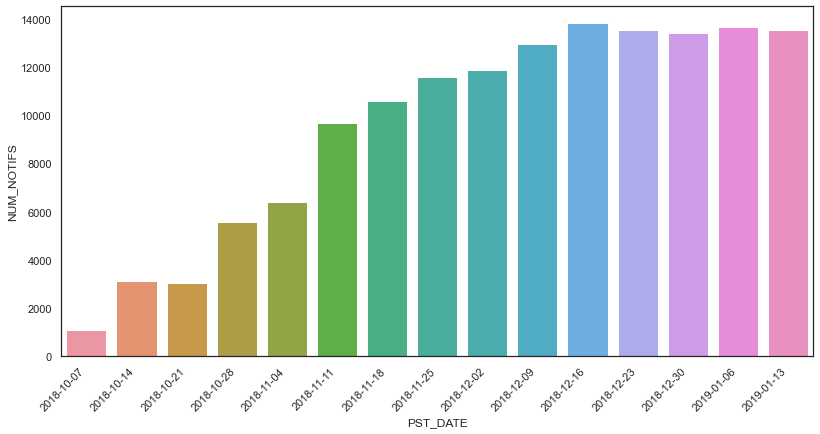

In [42]:
# PLOTTING
 
# plt.figure(figsize = (15,8))
features=df_cleaned.columns.tolist()[1:-1]
for feature in features:
    fig, ax = plt.subplots(figsize = (12,6)) 
    sns.barplot(x = 'PST_DATE', y = feature,data = df_W_AU_features_sum)
    x_dates = df_W_AU_UserID['PST_DATE'].dt.strftime('%Y-%m-%d').sort_values().unique()
    ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

### Note: total activity trends follows the trend of  activities per customer

### Calculate <ins> New App users 
use min() Date

In [50]:
# 
df_W_AU_mintime = df_W_AU.reset_index().groupby('USER_ID')['PST_DATE'].min().reset_index()
df_W_AU_mintime

,USER_ID,PST_DATE
0,164106,2018-11-04
1,185934,2018-11-04
2,277541,2018-11-18
3,423344,2018-10-28
4,427412,2018-10-28
...,...,...
6666,1519633,2018-12-30
6667,1519669,2018-12-23
6668,1520104,2018-12-23
6669,1520390,2018-12-23


In [65]:
df_W_AU_mintime = df_W_AU.reset_index().groupby('USER_ID')['PST_DATE'].min().reset_index()
df_W_AU_mintime.columns = ['USER_ID', 'PST_DATE_Min']

# #merge first purchase date column to our main dataframe (df_W_AU)
df_W_AU_merge = pd.merge(df_W_AU.reset_index(), df_W_AU_mintime, on='USER_ID')

df_W_AU_merge.head()

,USER_ID,PST_DATE,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS,PST_DATE_Min
0,164106,2018-11-04,0.000000,116.533330,0.000000,33.000000,0.000000,0.000000,2018-11-04
1,164106,2018-11-11,0.000000,111.370655,0.000000,77.142857,0.000000,0.000000,2018-11-04
2,164106,2018-11-18,4.000000,139.176591,2.714286,93.000000,0.285714,0.857143,2018-11-04
3,164106,2018-11-25,2.857143,135.454380,2.285714,91.000000,0.571429,1.571429,2018-11-04
4,164106,2018-12-02,2.714286,211.573673,2.857143,83.571429,0.428571,1.428571,2018-11-04


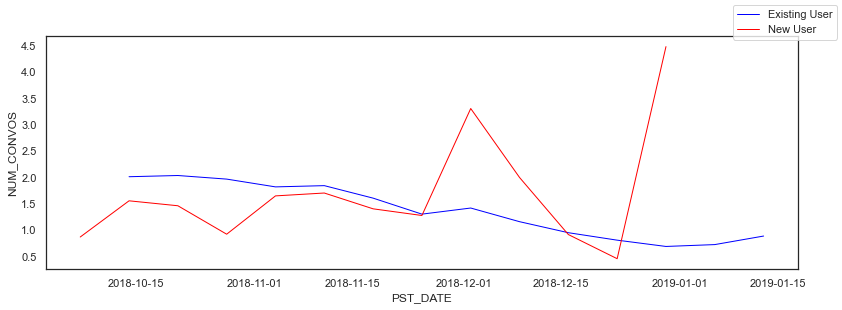

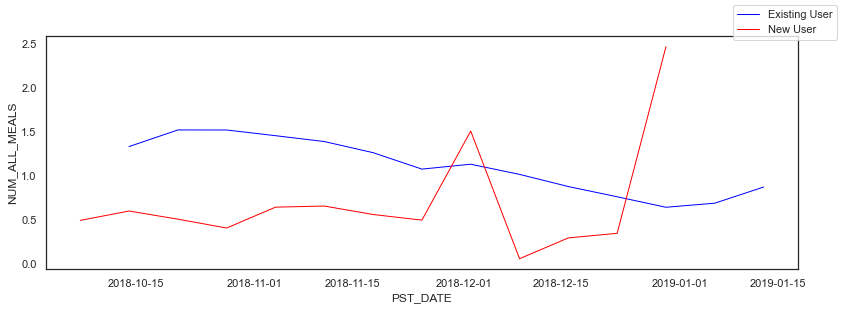

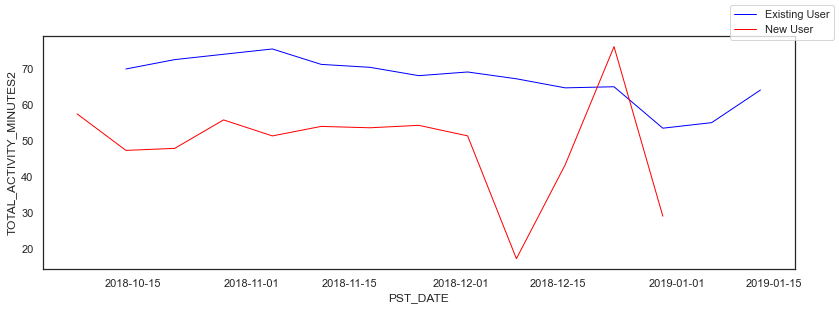

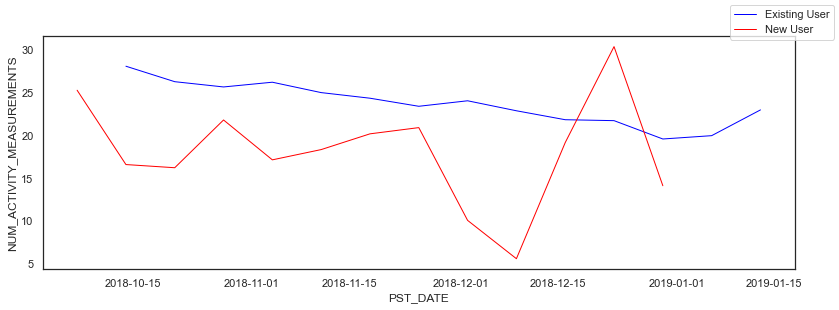

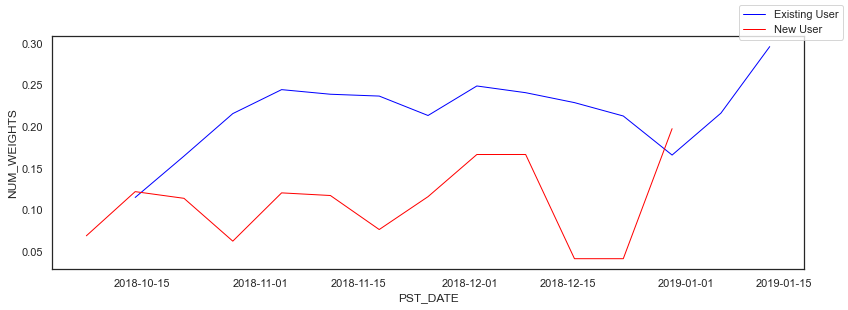

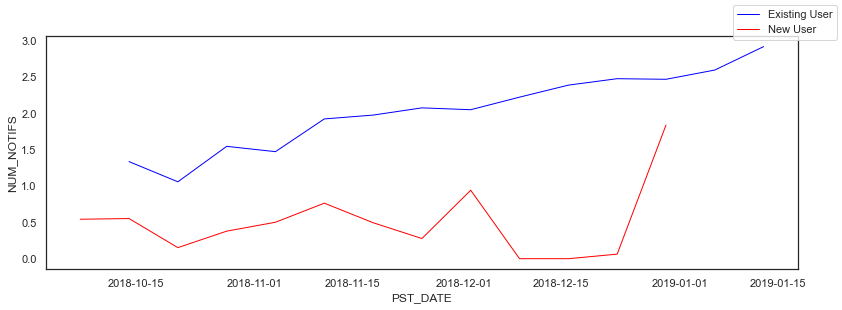

In [66]:
#create a dataframe contaning CustomerID and first activity date
df_W_AU_mintime = df_W_AU.reset_index().groupby('USER_ID')['PST_DATE'].min().reset_index()
df_W_AU_mintime.columns = ['USER_ID', 'PST_DATE_Min']

# #merge first purchase date column to our main dataframe (df_W_AU)
df_W_AU_merge = pd.merge(df_W_AU.reset_index(), df_W_AU_mintime, on='USER_ID')

df_W_AU_merge.head()
# #create a column called User Type and assign Existing 
# #if User's First activity date before the selected date
df_W_AU_merge['UserType'] = 'New'
df_W_AU_merge.loc[df_W_AU_merge['PST_DATE']>df_W_AU_merge['PST_DATE_Min'],'UserType'] = 'Existing'

features=df_cleaned.columns.tolist()[1:-1]
for feature in features:
    #calculate the Activity per week for each user type
    df_name='df_W_AU_merge'+feature
    df_name = df_W_AU_merge.groupby(['PST_DATE','UserType'])[feature].mean().reset_index()

    #filtering data for visualization
    x=df_name.query("UserType == 'Existing'")['PST_DATE']
    y=df_name.query("UserType == 'Existing'")[feature]

    x1=df_name.query("UserType == 'New'")['PST_DATE']
    y1=df_name.query("UserType == 'New'")[feature]
    
    #plot line charts
    fig = plt.figure(figsize=(12,4)) 
    sns.lineplot(x=x, y = y, data=df_name, color='blue', linewidth=1, legend=True)
    sns.lineplot(x=x1, y = y1, data=df_name, color='red', linewidth=1, legend=True)
    # fig.legend(bbox_to_anchor=(0., -0.3, 1., -0.4), mode="expand", ncol = 2)
    # fig.legend(['Existing User'])
    fig.legend(('Existing User', 'New User'),
          loc='upper right')




#### Observations
1. average Number of conversations for new users are similar or higher in new users
2. total activity minutes and measurements remain constantly high in existing users than new users. 
3. over all existing users through out holiday season, the activities maintain or slightly decrease with new users there are slightly fluxuating



### Let's look at <ins> new customer ratio

[Text(0, 0, '2018-10-14'),
 Text(1, 0, '2018-10-21'),
 Text(2, 0, '2018-10-28'),
 Text(3, 0, '2018-11-04'),
 Text(4, 0, '2018-11-11'),
 Text(5, 0, '2018-11-18'),
 Text(6, 0, '2018-11-25'),
 Text(7, 0, '2018-12-02'),
 Text(8, 0, '2018-12-09'),
 Text(9, 0, '2018-12-16'),
 Text(10, 0, '2018-12-23'),
 Text(11, 0, '2018-12-30')]

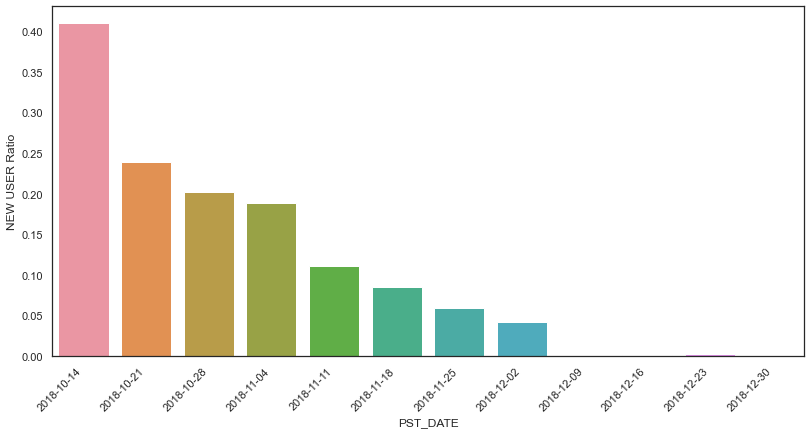

In [67]:
#new users /existing users
df_W_AU_merge_ratio = df_W_AU_merge.query("UserType == 'New'").groupby(['PST_DATE'])['USER_ID'].nunique()/df_W_AU_merge.query("UserType == 'Existing'").groupby(['PST_DATE'])['USER_ID'].nunique() 
df_W_AU_merge_ratio = df_W_AU_merge_ratio.reset_index()
df_W_AU_merge_ratio = df_W_AU_merge_ratio.dropna()
df_W_AU_merge_ratio.columns=['PST_DATE','NEW USER Ratio']
#print the dafaframe
df_W_AU_merge_ratio
fig, ax = plt.subplots(figsize = (12,6)) 
sns.barplot(x = 'PST_DATE', y = 'NEW USER Ratio', data= df_W_AU_merge_ratio)
x_dates = df_W_AU_merge_ratio['PST_DATE'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

***Note***
New Customer Ratio has declined as expected (we assumed on Oct, all customers were New) and running around december decrease quickly.

### <ins> Weekly Retention Rate
1. Weekly Retention Rate = Retained Customers From Prev. Week/Active Customers Total
2. Run out of time, did not continue...

<ipython-input-68-fa7877382791>:34: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


[Text(-20.0, 0, '2018-10-14'),
 Text(0.0, 0, '2018-10-21'),
 Text(20.0, 0, '2018-10-28'),
 Text(40.0, 0, '2018-11-04'),
 Text(60.0, 0, '2018-11-11'),
 Text(80.0, 0, '2018-11-18'),
 Text(100.0, 0, '2018-11-25'),
 Text(120.0, 0, '2018-12-02'),
 Text(140.0, 0, '2018-12-09'),
 Text(160.0, 0, '2018-12-16')]

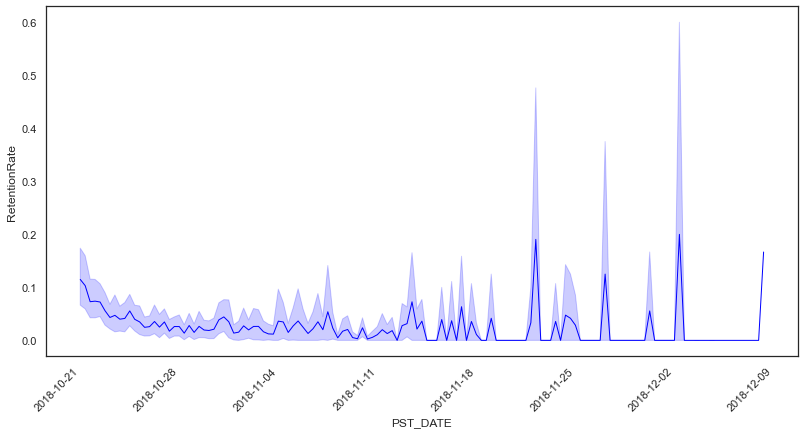

In [68]:
#df_W_AU_merge_ratio = df_W_AU_merge.query("UserType == 'New'").groupby(['PST_DATE'])['USER_ID'].nunique()/df_W_AU_merge.query("UserType == 'Existing'").groupby(['PST_DATE'])['USER_ID'].nunique() 

#identify which users are active by looking at their average activity measurements per week
df_W_AU_merge_active =  df_W_AU_merge.groupby(['USER_ID','PST_DATE'])['NUM_ACTIVITY_MEASUREMENTS'].mean().reset_index()

#create retention matrix with crosstab
df_W_AU_retention = pd.crosstab(df_W_AU_merge_active['USER_ID'], df_W_AU_merge_active['NUM_ACTIVITY_MEASUREMENTS']).reset_index()

df_W_AU_retention.head()

# create an array of dictionary which keeps Retained & Total User count for each month
weeks = df_W_AU_retention.columns[2:]
retention_array = []
for i in range(len(weeks)-1):
    retention_data = {}
    selected_week = weeks[i+1]
    prev_week = weeks[i]
    retention_data['PST_DATE'] = int(selected_week)
    retention_data['TotalUserCount'] = df_W_AU_retention[selected_week].sum()
    retention_data['RetainedUserCount'] = df_W_AU_retention[(df_W_AU_retention[selected_week]>0) & (df_W_AU_retention[prev_week]>0)][selected_week].sum()
    retention_array.append(retention_data)
    

#convert the array to dataframe and calculate Retention Rate
df_W_AU_retention = pd.DataFrame(retention_array)
df_W_AU_retention['RetentionRate'] = df_W_AU_retention['RetainedUserCount']/df_W_AU_retention['TotalUserCount']

x=df_W_AU_retention['PST_DATE']
y=df_W_AU_retention['RetentionRate']

fig, ax = plt.subplots(figsize = (12,6)) 
sns.lineplot(x=x, y = y, data=df_W_AU_retention, color='blue', linewidth=1, legend=True)
# x_dates = df_W_AU_retention['PST_DATE'].dt.strftime('%Y-%m-%d').sort_values().unique()
ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')

***Note***: could investigate more later on. Need more QC on why the retention rate is spiky

### 1. Check at user level aggregattion= sum
overall statistics to compare different behavior among users

In [69]:
#group by user only
df_uid_sum = df_users.groupby('USER_ID').agg({'NUM_CONVOS' : sum,
                                 'TOTAL_ACTIVITY_MINUTES2' : sum,
                                 'NUM_ALL_MEALS': sum,
                                 'NUM_ACTIVITY_MEASUREMENTS': sum,
                                 'NUM_WEIGHTS': sum,
                                 'NUM_NOTIFS': sum,
                                  'ANA': np.mean
                                                   })

<AxesSubplot:>

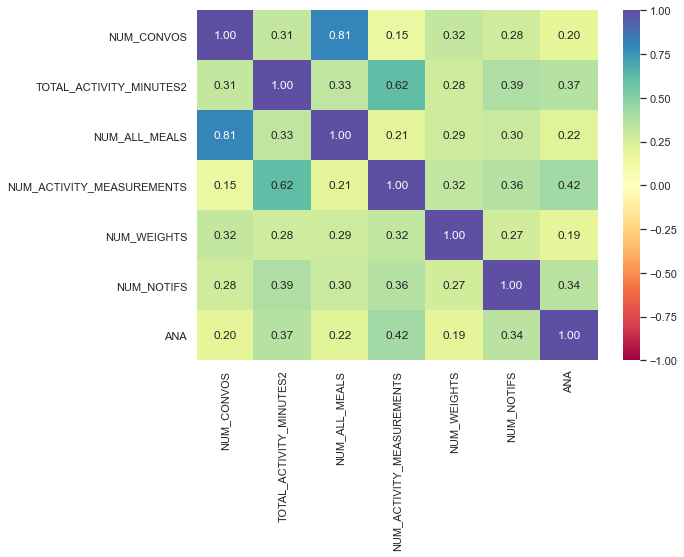

In [70]:
cm1=df_uid_sum.corr()
# heatmap
fig = plt.figure(figsize=(8,6)) 
sns.heatmap(cm1, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

***Note*** few observations are 
1. Number of Meals has strong correlation with number of conversations; it could be explained by get active group
2. Number of activity measurement strong correlation with number of activities minutes. 
3. while these are interesting, but they are not insightful to our questions
4. also active users have higher correlation between activity minutes, num_activity measurements and num of notification, which makes sense since it is how we created the feature.

#### Plot histogram of numeric Columns of cum data of all user_id:

In [71]:
df_uid_sum.columns

Index(['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'ANA'],
      dtype='object')

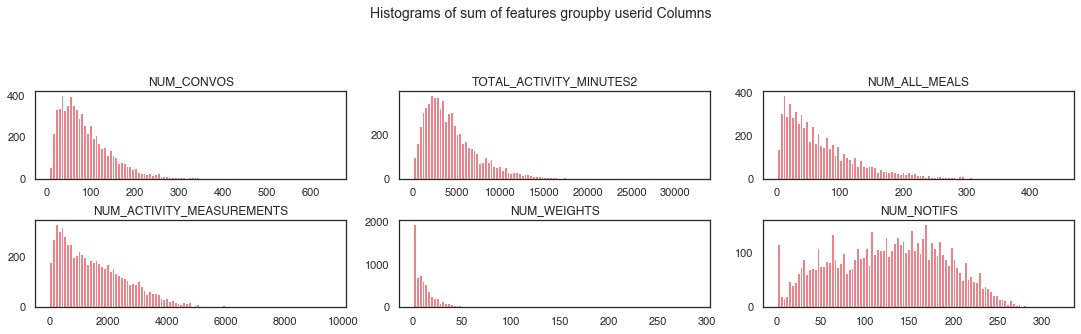

In [233]:
dataset2 = df_uid_sum[['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS']]
#Histogram:
    
fig = plt.figure(figsize=(15, 12))
plt.suptitle('Histograms of sum of features groupby userid Columns\n',horizontalalignment="center",fontstyle = "normal", fontsize = 14, fontfamily = "sans-serif")
for i in range(dataset2.shape[1]):
    plt.subplot(6, 3, i + 1)
    f = plt.gca()
    f.set_title(dataset2.columns.values[i])
    
    vals = np.size(dataset2.iloc[:, i].unique())
    if vals >= 100:
        vals = 100
    
    plt.hist(dataset2.iloc[:, i], bins=vals, color = '#ec838a')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])

###  check individual user behavior change weekly
**Main Goals are**
1. add features of engagement change 
2.understand why the engagement decrease

In [234]:
df_W_avg = df_users.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean
                                                   })

In [74]:
# df_M1=df_M

df_W_avg.reset_index().set_index('PST_DATE')


,USER_ID,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
PST_DATE,,,,,,,
2018-11-04,164106,0.000000,116.533330,0.000000,33.000000,0.000000,0.000000
2018-11-11,164106,0.000000,111.370655,0.000000,77.142857,0.000000,0.000000
2018-11-18,164106,4.000000,139.176591,2.714286,93.000000,0.285714,0.857143
2018-11-25,164106,2.857143,135.454380,2.285714,91.000000,0.571429,1.571429
2018-12-02,164106,2.714286,211.573673,2.857143,83.571429,0.428571,1.428571
...,...,...,...,...,...,...,...
2019-01-06,1520390,3.666667,32.408334,2.833333,19.333333,0.000000,1.333333
2018-12-23,1520428,0.000000,84.482331,0.000000,75.500000,0.000000,0.000000
2018-12-30,1520428,1.571429,124.176190,0.571429,52.857143,0.142857,0.000000


In [75]:
df_W_avg.describe()

,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS
count,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000,72607.000000
mean,1.290616,65.171622,1.014140,23.017944,0.211446,1.981413
std,1.418955,52.258552,1.188920,17.532010,0.406666,1.130329
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,28.895238,0.000000,8.714286,0.000000,1.142857
50%,1.000000,53.709524,0.571429,20.571429,0.000000,2.142857
75%,2.000000,88.783767,1.714286,34.285714,0.285714,2.857143
max,14.000000,490.721703,7.000000,138.000000,6.000000,5.000000


In [90]:
#Generate Delta Features
def create_delta_features(X):
    df_M1=X
    df_M1['Delta_TAM']=df_M1.groupby('USER_ID')['TOTAL_ACTIVITY_MINUTES2'].diff()
    df_M1['Delta_Nmeas']=df_M1.groupby('USER_ID')['NUM_ACTIVITY_MEASUREMENTS'].diff()
    df_M1['Delta_NConv']=df_M1.groupby('USER_ID')['NUM_CONVOS'].diff()
    df_M1['Delta_NWgts']=df_M1.groupby('USER_ID')['NUM_WEIGHTS'].diff()
    #reset index to allow time indexing
    df_M1=df_M1.reset_index().set_index('PST_DATE')
    #Create holiday feature dec-Jan
    df_M1['Holidays']=0
    df_M1.loc[(df_M1.index.month==12 )|(df_M1.index.month==1 ) , 'Holidays'] = 1
    #create ANA feature
    df_M1['ANA']=1
    df_M1.loc[(df_M1['TOTAL_ACTIVITY_MINUTES2']==0),'ANA']=0
    df_W_avg=df_M1
    return df_W_avg


In [91]:
create_delta_features(df_W_avg)

,USER_ID,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS,Delta_TAM,Delta_Nmeas,Delta_NConv,Delta_NWgts,Holidays,ANA
PST_DATE,,,,,,,,,,,,,
2018-11-04,164106,0.000000,116.533330,0.000000,33.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,0,1
2018-11-11,164106,0.000000,111.370655,0.000000,77.142857,0.000000,0.000000,-5.162675,44.142857,0.000000,0.000000,0,1
2018-11-18,164106,4.000000,139.176591,2.714286,93.000000,0.285714,0.857143,27.805936,15.857143,4.000000,0.285714,0,1
2018-11-25,164106,2.857143,135.454380,2.285714,91.000000,0.571429,1.571429,-3.722211,-2.000000,-1.142857,0.285714,0,1
2018-12-02,164106,2.714286,211.573673,2.857143,83.571429,0.428571,1.428571,76.119293,-7.428571,-0.142857,-0.142857,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-01-06,1520390,3.666667,32.408334,2.833333,19.333333,0.000000,1.333333,-12.651190,-6.523810,2.809524,-0.142857,1,1
2018-12-23,1520428,0.000000,84.482331,0.000000,75.500000,0.000000,0.000000,NaN,NaN,NaN,NaN,1,1
2018-12-30,1520428,1.571429,124.176190,0.571429,52.857143,0.142857,0.000000,39.693859,-22.642857,1.571429,0.142857,1,1


In [92]:
df_W_avg.columns

Index(['USER_ID', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Delta_TAM',
       'Delta_Nmeas', 'Delta_NConv', 'Delta_NWgts', 'Holidays', 'ANA'],
      dtype='object')

<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_Nmeas'>

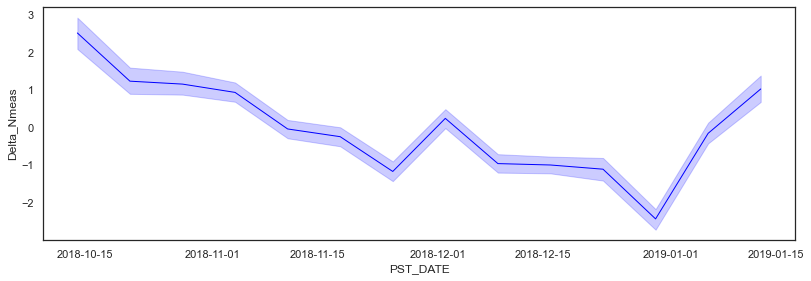

In [79]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_Nmeas'], color='blue', linewidth=1)


<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_NConv'>

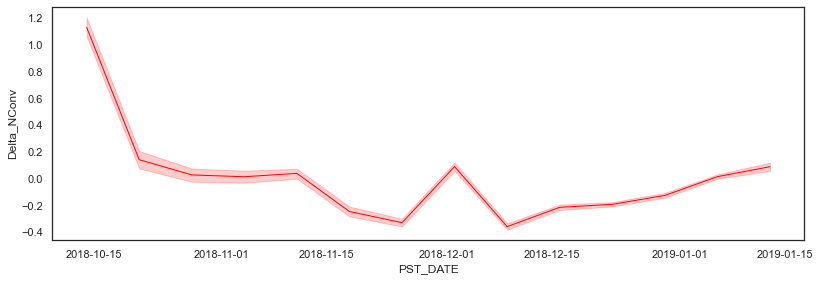

In [80]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_NConv'], color='red', linewidth=1)


<AxesSubplot:xlabel='PST_DATE', ylabel='Delta_NWgts'>

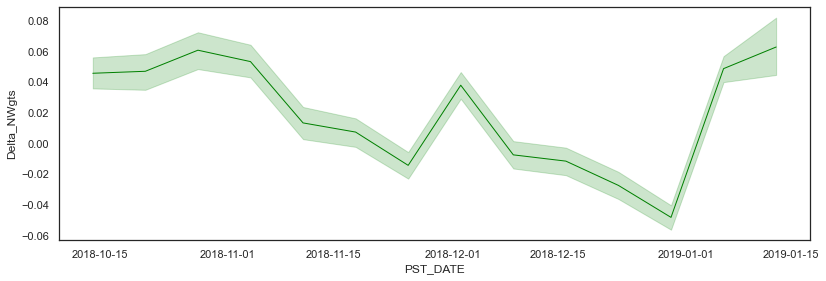

In [81]:
fig = plt.figure(figsize=(12,4)) 

sns.lineplot(data=df_W_avg['Delta_NWgts'], color='green', linewidth=1)

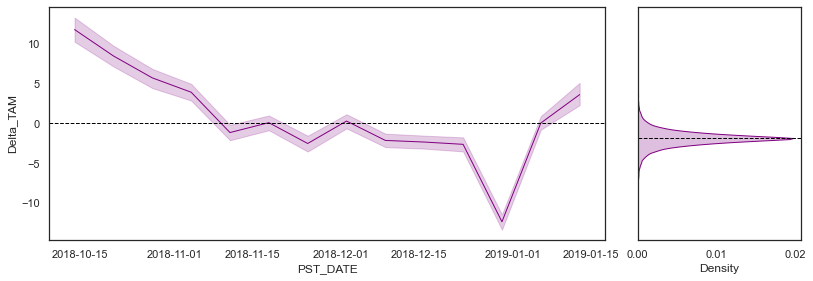

In [82]:
# differences in body mass time series and density
fig = plt.figure(figsize=(12,4)) 

# place and size subplots
ax1 = plt.subplot2grid(shape=(1, 4), loc=(0, 0), colspan=3) 
ax2 = plt.subplot2grid(shape=(1, 4), loc=(0, 3), colspan=1)

# the plots
sns.lineplot(ax=ax1, data=df_W_avg['Delta_TAM'], color='purple', linewidth=1)
sns.kdeplot(data=df_W_avg, y='Delta_TAM', color='purple', fill=True, label='', ax=ax2)

# some cosmetic changes
ax1.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
ax2.axhline(y=0.0, color='black', linestyle='--', linewidth=1)
ax2.axes.yaxis.set_visible(False)

<AxesSubplot:>

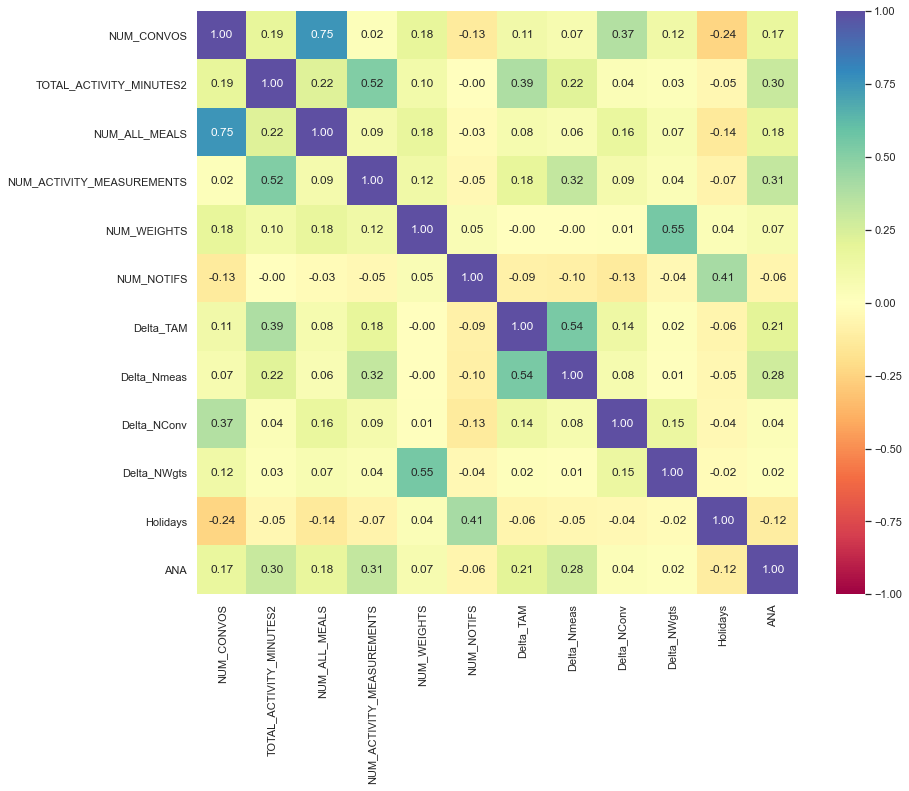

In [83]:
# correlation matrix
cm = df_W_avg.iloc[:,1:].corr()

# heatmap
fig = plt.figure(figsize=(12,10)) 
sns.heatmap(cm, annot=True, fmt=".2f", vmin=-1.0, vmax=+1.0, cmap='Spectral')

# identify a random selected user_id disengagement

In [85]:
#Select one id to investigate
df_raw1=df_raw[df_raw['USER_ID']==1212312]
df_raw1=df_raw1.reset_index().set_index('PST_DATE')


In [86]:
#group by resample and aggregate

df_W_mean = df_raw.groupby('USER_ID').resample('W').agg({'NUM_CONVOS' : np.mean,
                                 'TOTAL_ACTIVITY_MINUTES2' : np.mean,
                                 'NUM_ALL_MEALS': np.mean,
                                 'NUM_ACTIVITY_MEASUREMENTS': np.mean,
                                 'NUM_WEIGHTS': np.mean,
                                 'NUM_NOTIFS': np.mean,
                                                   })

array([<AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>], dtype=object)

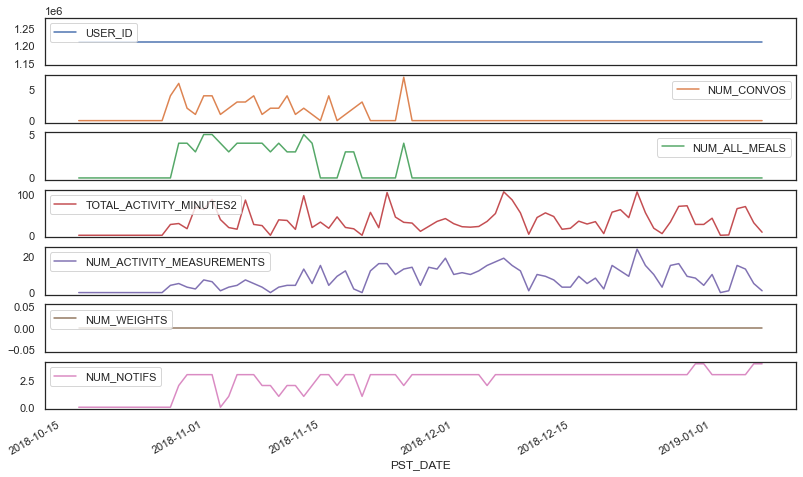

In [87]:
#line plot for raw data
df_raw1.plot(subplots=True,figsize=(12,8))


***Note***: this is a typical user in a group "get active"

### Resampel to simplify the dataset

array([<AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>, <AxesSubplot:xlabel='PST_DATE'>,
       <AxesSubplot:xlabel='PST_DATE'>], dtype=object)

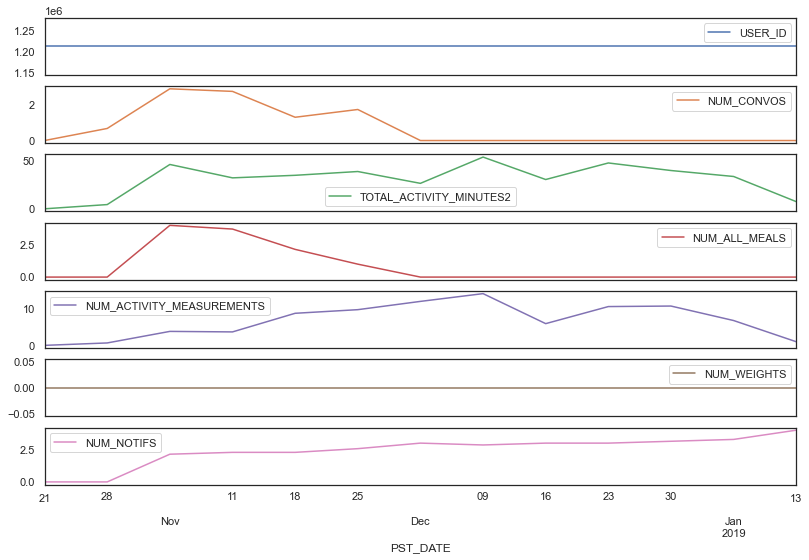

In [93]:
# reindex the dataframe so we can add features
df_W2=df_W_mean.reset_index().set_index('PST_DATE')
df_W2=df_W2[df_W2['USER_ID']==1212312]
df_W2.plot(subplots=True,figsize=(12,8))

**Note** resampeled data keep the same trend as daily data 

### Generate user engagement metrics: Simplified Approach to see if we can generate any insights


### Metrics
1. Average_excercise_time per person per month
2. Avg Number of activity per user per month

In [94]:
df_W1=df_W_mean
df_W1['W_Delta_TAM']=df_W1.groupby('USER_ID')['TOTAL_ACTIVITY_MINUTES2'].diff()
df_W1['W_Delta_MEASU']=df_W1.groupby('USER_ID')['NUM_ACTIVITY_MEASUREMENTS'].diff()



In [102]:
df_W1.reset_index(inplace=True)

In [104]:
df_W1['Holidays']=0
df_W1.loc[(df_W1.PST_DATE.dt.month==12)|(df_W1.PST_DATE.dt.month==1 ) , 'Holidays'] = 1

In [105]:
df_W1=df_W1[['USER_ID', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS',
       'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS', 'Holidays', 'W_Delta_TAM', 'W_Delta_MEASU']]

***create feature of feature change with time***

# Merge Agg statistics with User Mission time  
### New features created <ins> CNC and CR
CNC=Find out complete or not complete feature \
CR=Completion Rate

In [108]:
df_mission = pd.read_csv('user_mission.csv', na_values="Not Available")

display(df_mission.shape)
display(df_mission.sort_values(by="USER_ID").head(5))

(27983, 4)

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
17527,2018-12-04 16:40:00+00:00,2018-12-11 06:04:51+00:00,True,164106
17528,2018-12-25 20:02:47+00:00,2019-02-06 20:17:07+00:00,True,164106
17529,2018-11-14 06:10:21+00:00,2018-11-20 20:53:53+00:00,True,164106
17530,2018-12-17 15:20:50+00:00,2018-12-25 20:02:47+00:00,True,164106
17531,2018-11-20 20:53:53+00:00,2018-11-27 17:21:38+00:00,True,164106


***Mission data*** it is time depeneded, it tells us about when it completed and we need to join it with first table and try to understand more 

In [109]:
df_mission.columns
df_mission.head()
df_mission.isnull().sum()

START_TIMESTAMP       0
END_TIMESTAMP      3991
COMPLETED             0
USER_ID               0
dtype: int64

### Mission Not complete

In [110]:
#visualize missing data
df_mission.loc[df_mission['END_TIMESTAMP'].isnull()]
df_mission[df_mission['COMPLETED']==False]

,START_TIMESTAMP,END_TIMESTAMP,COMPLETED,USER_ID
1,2018-10-16 00:23:35+00:00,NaN,False,1411458
4,2018-11-10 18:43:20+00:00,NaN,False,1424093
8,2018-12-01 22:15:11+00:00,NaN,False,1418958
12,2018-11-02 17:30:14+00:00,NaN,False,1445159
13,2018-11-08 13:37:25+00:00,NaN,False,1449004
...,...,...,...,...
27937,2018-11-18 03:42:16+00:00,NaN,False,1463782
27955,2018-12-24 05:41:36+00:00,NaN,False,1208291
27963,2018-11-13 01:21:44+00:00,NaN,False,1408642
27972,2018-11-15 12:52:34+00:00,NaN,False,1458694


### Add new feature completion <ins> length

In [111]:
df_mission['END_TIMESTAMP'] = pd.to_datetime(df_mission['END_TIMESTAMP'], errors='coerce')
df_mission['START_TIMESTAMP'] = pd.to_datetime(df_mission['START_TIMESTAMP'], errors='coerce')

In [112]:
#how many days to complete the mission
df_mission['length']=df_mission['END_TIMESTAMP']-df_mission['START_TIMESTAMP']

df_mission['length']= df_mission['length'].dt.days
df_mission_delta=df_mission[['START_TIMESTAMP','USER_ID', 'length', 'COMPLETED' ]].reset_index()

df_mission_delta.set_index('START_TIMESTAMP', inplace=True)

<AxesSubplot:>

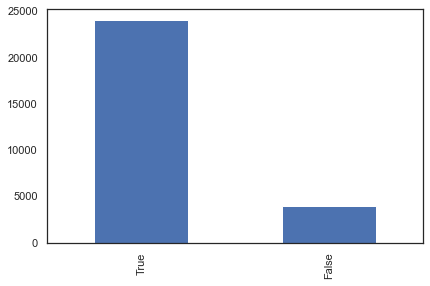

In [113]:
df_mission_delta.COMPLETED.value_counts().plot(kind='bar')

***Note*** Majority of missions was completed

In [114]:
#findout weekly active user resample by week and average over all features
df_mission_AU = df_mission_delta.groupby('USER_ID').resample('W').agg({'COMPLETED' : sum,
                                 'length' : np.mean })
df_mission_AU.reset_index(inplace=True)

In [115]:
df_mission_AU.columns

Index(['USER_ID', 'START_TIMESTAMP', 'COMPLETED', 'length'], dtype='object')

In [116]:
#rename the columns 
df_mission_AU.columns=['USER_ID', 'START_TIMESTAMP', 'CNC', 'DaystoComplete']
df_mission_AU.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 33757 entries, 0 to 33756
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   USER_ID          33757 non-null  int64              
 1   START_TIMESTAMP  33757 non-null  datetime64[ns, UTC]
 2   CNC              33757 non-null  int64              
 3   DaystoComplete   23383 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(1), int64(2)
memory usage: 1.0 MB


[Text(0.5, 1.0, 'Days of Mission Completion vs. Start Time')]

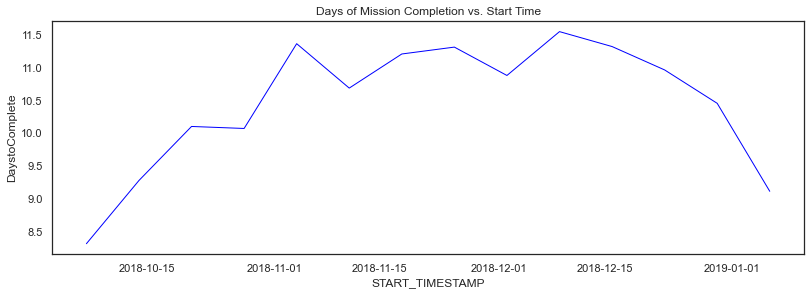

In [122]:
# features=df_cleaned.columns.tolist()[1:-1]
# for feature in features:
df_mission_AU_avg = df_mission_AU.groupby(['START_TIMESTAMP'])['DaystoComplete'].mean().reset_index()
#     df_W_AU_avg
fig = plt.figure(figsize=(12,4)) 
sns.lineplot(x='START_TIMESTAMP', y = 'DaystoComplete',  data=df_mission_AU_avg, 
             color='blue', linewidth=1, legend=True).set(title='Days of Mission Completion vs. Start Time')


In [ ]:
df_cleaned.columns

# Comparing Mission with other aggregated statistics

<AxesSubplot:xlabel='START_TIMESTAMP', ylabel='DaystoComplete'>

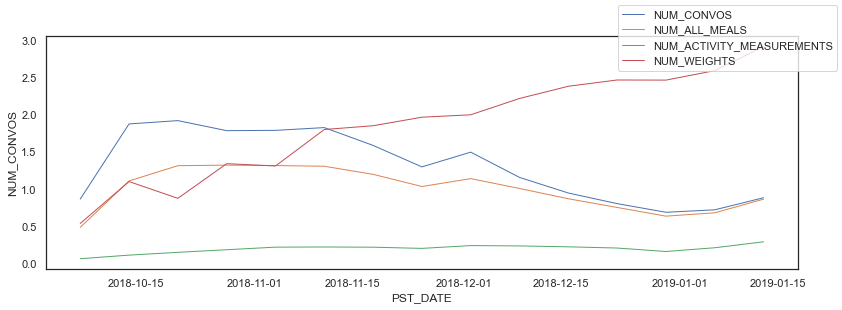

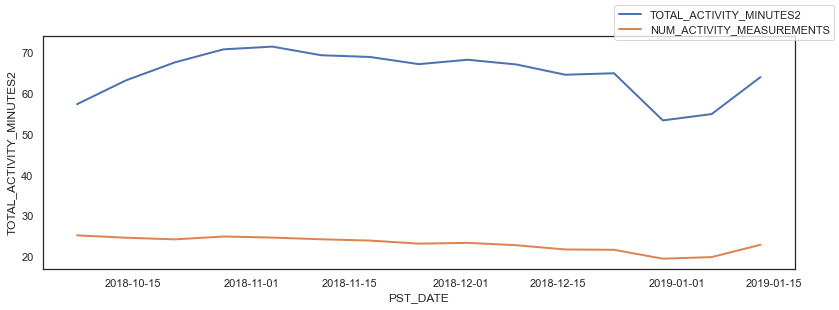

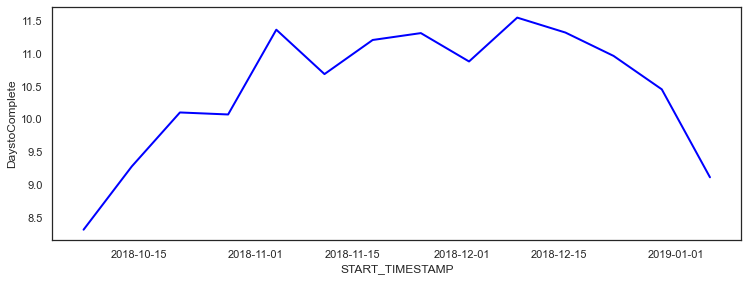

In [123]:
# features=df_cleaned.columns.tolist()[1:-1]
features=['NUM_CONVOS', 'NUM_ALL_MEALS', 'NUM_WEIGHTS', 'NUM_NOTIFS']
fig = plt.figure(figsize=(12,4))
for feature in features:
    df_W_AU_avg = df_W_AU.groupby(['PST_DATE'])[feature].mean().reset_index()
#     df_W_AU_avg
 
    sns.lineplot(x='PST_DATE', y = feature, data=df_W_AU_avg,  linewidth=1, legend=True)
fig.legend(('NUM_CONVOS', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS'),
          loc='upper right')


features=['TOTAL_ACTIVITY_MINUTES2','NUM_ACTIVITY_MEASUREMENTS']
fig = plt.figure(figsize=(12,4))
for feature in features:
    df_W_AU_avg = df_W_AU.groupby(['PST_DATE'])[feature].mean().reset_index()
#     df_W_AU_avg
 
    sns.lineplot(x='PST_DATE', y = feature, data=df_W_AU_avg,  linewidth=2, legend=True)
fig.legend(('TOTAL_ACTIVITY_MINUTES2','NUM_ACTIVITY_MEASUREMENTS'),
          loc='upper right')
fig = plt.figure(figsize=(11,4))
sns.lineplot(x='START_TIMESTAMP', y = 'DaystoComplete',  data=df_mission_AU_avg, color='blue', linewidth=2, legend=True)


### Visually check, there might be correlation between mission completion date and the total activity minutes. 
It is worthwhile to check what kind of mission is completed; if majority of them are tracking excercises like walking. It might make sense.

In [124]:

df_mission_agg = df_mission.groupby(['USER_ID'])['COMPLETED'].describe()

In [125]:
df_mission_agg.head()

,count,unique,top,freq
USER_ID,,,,
164106,7,1,True,7
185934,3,2,True,2
277541,3,1,True,3
423344,1,1,False,1
427412,8,1,True,8


***Note*** define user Mission Completion Rate 
0 not complete at all 1 complete 100 percent

In [126]:
# df_mission_agg[(df_mission_agg['top']==True),'CR']
df_mission_agg['CR']=df_mission_agg['freq']/df_mission_agg['count']
df_mission_agg['Flag']=df_mission_agg['top'].apply(lambda x: 1 if x==True else 0)
df_mission_agg['CR']=df_mission_agg['CR']*df_mission_agg['Flag']

[Text(0, 0, '0.0'),
 Text(1, 0, '0.67'),
 Text(2, 0, '0.75'),
 Text(3, 0, '0.8'),
 Text(4, 0, '0.83'),
 Text(5, 0, '0.86'),
 Text(6, 0, '0.88'),
 Text(7, 0, '0.89'),
 Text(8, 0, '0.9'),
 Text(9, 0, '0.91'),
 Text(10, 0, '0.92'),
 Text(11, 0, '0.92'),
 Text(12, 0, '1.0')]

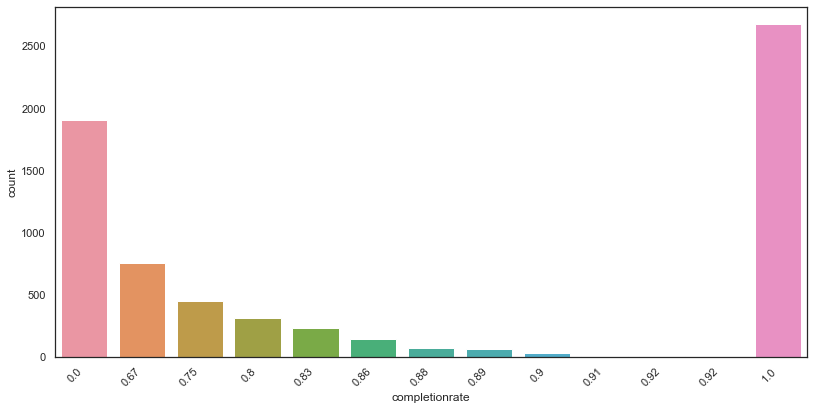

In [127]:
hist=pd.DataFrame(df_mission_agg.CR.value_counts())
hist.sort_index(inplace=True)
hist.reset_index(inplace=True)
hist.columns=['completionrate', 'count']
hist.completionrate.round(decimals=2)
fig, ax = plt.subplots(figsize = (12,6)) 
sns.barplot(x='completionrate', y='count', data=hist)
ax.set_xticklabels(labels=hist.completionrate.round(decimals=2), rotation=45, ha='right')

**Note** Bimodel distribution of completion rate, 0 or 100 percent there are large group of users complete 67% or above of their missions.The goal is to motivate users to move from 100% completion rate

# Join Mission data with Aggregated statistics on UserID 

In [128]:
New_df_W_AU_sum=df_W_AU.join(df_mission_agg, how='left', on='USER_ID')


In [131]:
New_df_W_AU_sum.reset_index(inplace= True)

In [132]:
#select features for further study
New_df_W_AU_combined=New_df_W_AU_sum[['USER_ID', 'PST_DATE', 'NUM_CONVOS',
       'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS',
       'NUM_WEIGHTS', 'NUM_NOTIFS', 'count', 'unique', 'freq', 'CR',
       'Flag']]
New_df_W_AU_combined.columns=['USER_ID', 'PST_DATE', 'NUM_CONVOS',
       'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS',
       'NUM_WEIGHTS', 'NUM_NOTIFS', 'NUM_MISSIONS', 'unique', 'NUM_MISSION_COMP', 'MISSION_COMP_RATE',
       'CompletionFlag']
New_df_W_AU_combined.head()

,USER_ID,PST_DATE,NUM_CONVOS,TOTAL_ACTIVITY_MINUTES2,NUM_ALL_MEALS,NUM_ACTIVITY_MEASUREMENTS,NUM_WEIGHTS,NUM_NOTIFS,NUM_MISSIONS,unique,NUM_MISSION_COMP,MISSION_COMP_RATE,CompletionFlag
0,164106,2018-11-04,0.000000,116.533330,0.000000,33.000000,0.000000,0.000000,7,1,7,1.0,1
1,164106,2018-11-11,0.000000,111.370655,0.000000,77.142857,0.000000,0.000000,7,1,7,1.0,1
2,164106,2018-11-18,4.000000,139.176591,2.714286,93.000000,0.285714,0.857143,7,1,7,1.0,1
3,164106,2018-11-25,2.857143,135.454380,2.285714,91.000000,0.571429,1.571429,7,1,7,1.0,1
4,164106,2018-12-02,2.714286,211.573673,2.857143,83.571429,0.428571,1.428571,7,1,7,1.0,1


In [133]:
New_df_W_AU_combined.columns

Index(['USER_ID', 'PST_DATE', 'NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2',
       'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS',
       'NUM_NOTIFS', 'NUM_MISSIONS', 'unique', 'NUM_MISSION_COMP',
       'MISSION_COMP_RATE', 'CompletionFlag'],
      dtype='object')

In [134]:
# New_df_uid_sum.info()
features=['unique', 'NUM_MISSION_COMP','MISSION_COMP_RATE']
# New_df_uid_sum[['count', 'unique', 'freq', 'CR', 'Flag']].astype(float)
for feature in features:
    New_df_W_AU_combined[feature] = pd.to_numeric(New_df_W_AU_combined[feature])
# New_df_uid_sum.drop(['top'],axis=1, inplace=True)

<ipython-input-134-1902cee588dd>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  New_df_W_AU_combined[feature] = pd.to_numeric(New_df_W_AU_combined[feature])


<ipython-input-135-c5b8a66baa27>:9: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(corr, dtype=np.bool)


<AxesSubplot:>

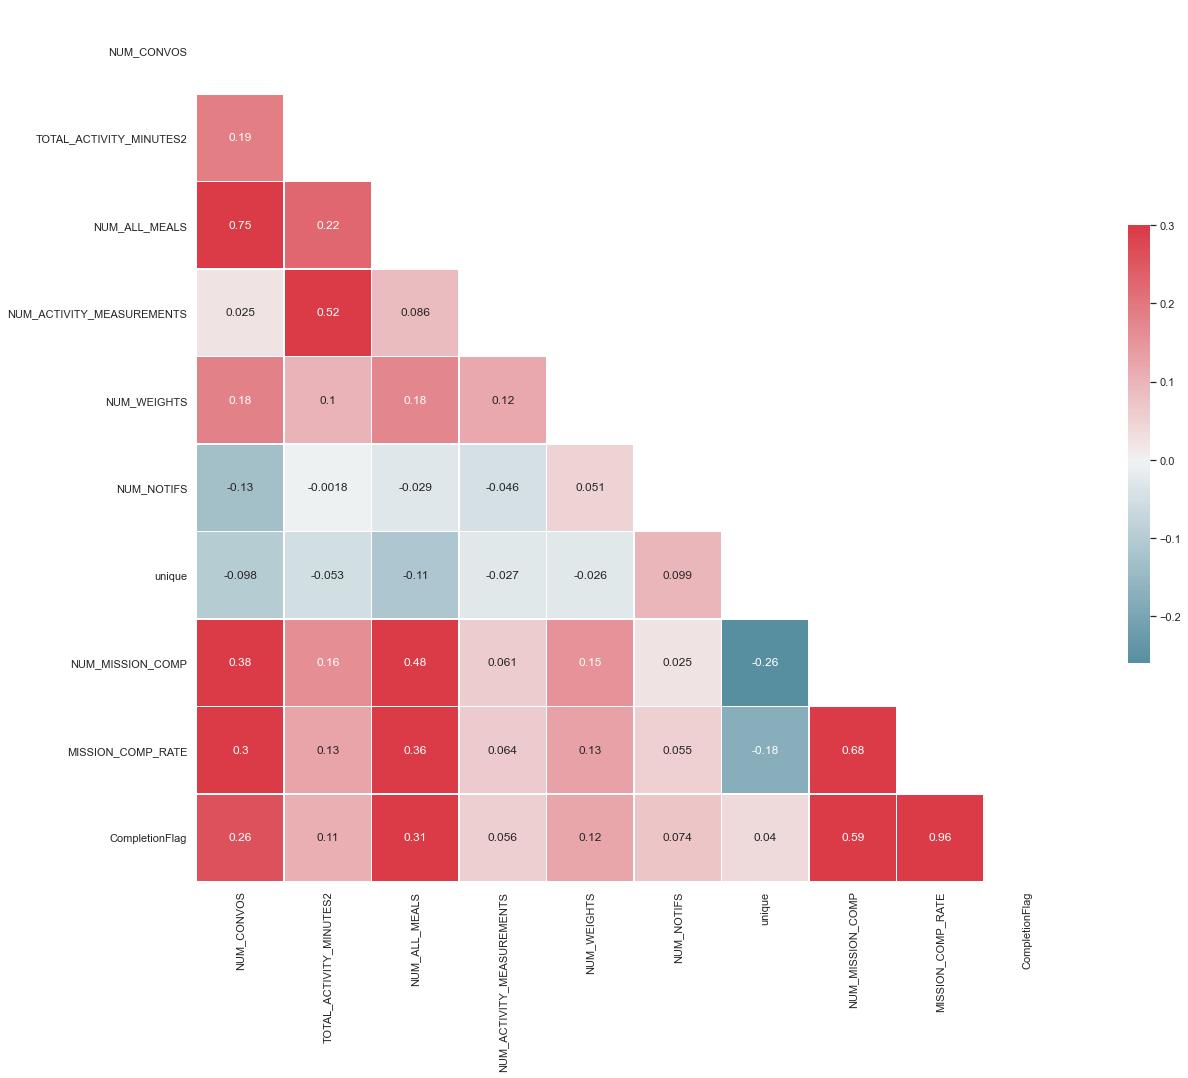

In [135]:
# df_cleaned.describe()
datacorr=New_df_W_AU_combined.iloc[:, 1:]

#Set and compute the Correlation Matrix:
sns.set(style="white")
corr = datacorr.corr()

#Generate a mask for the upper triangle:
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
#Set up the matplotlib figure and a diverging colormap:
f, ax = plt.subplots(figsize=(18, 15))
cmap = sns.diverging_palette(220, 10, as_cmap=True)
#Draw the heatmap with the mask and correct aspect ratio:
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0, annot=True, 
square=True, linewidths=.5, cbar_kws={"shrink": .5})

***Observation***: People use apps for tracking meals or conversation (aka social social group) tends to have high strong correlation with Completion Rate 

## Visualize Data
useful insights. lets visualize data in historgrams


In [136]:
import dexplot as dxp

In [261]:
features=New_df_W_AU_combined.columns.tolist()
features[2:-5]

['NUM_CONVOS',
 'TOTAL_ACTIVITY_MINUTES2',
 'NUM_ALL_MEALS',
 'NUM_ACTIVITY_MEASUREMENTS',
 'NUM_WEIGHTS',
 'NUM_NOTIFS']

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


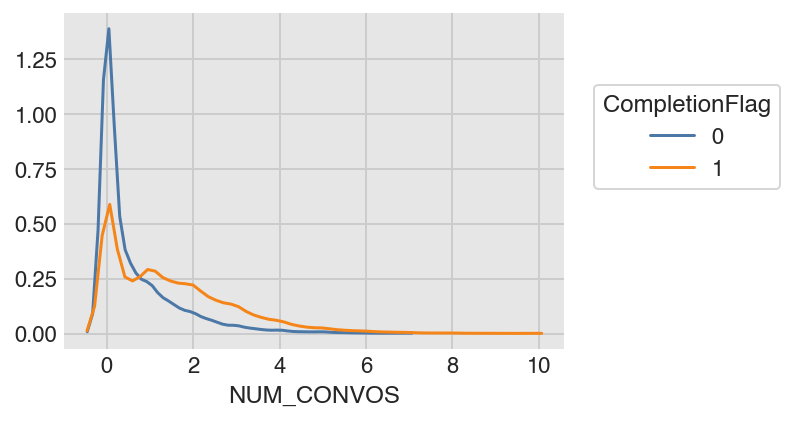

In [137]:

dxp.kde(x="NUM_CONVOS", data=New_df_W_AU_combined.dropna(), split='CompletionFlag', split_order=[0,1])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


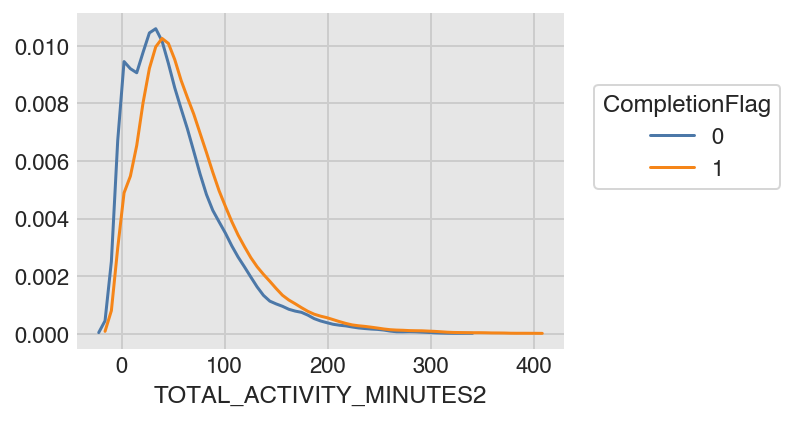

In [264]:

dxp.kde(x="TOTAL_ACTIVITY_MINUTES2", data=New_df_W_AU_combined.dropna(), split='CompletionFlag', split_order=[0,1])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


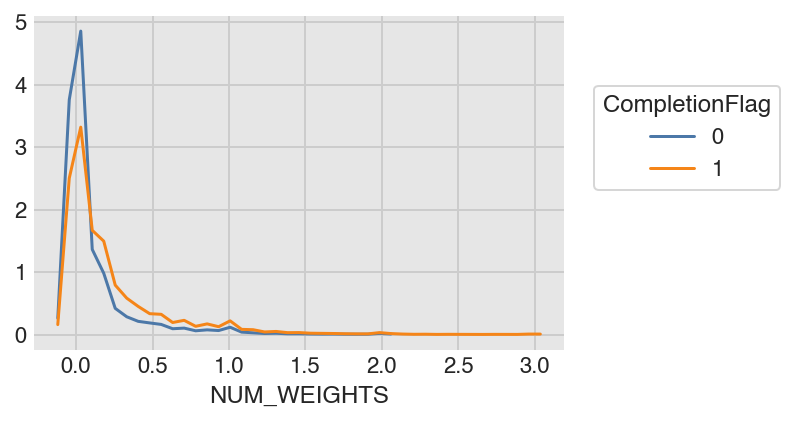

In [267]:

dxp.kde(x='NUM_WEIGHTS', data=New_df_W_AU_combined.dropna(), split='CompletionFlag', split_order=[0,1])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


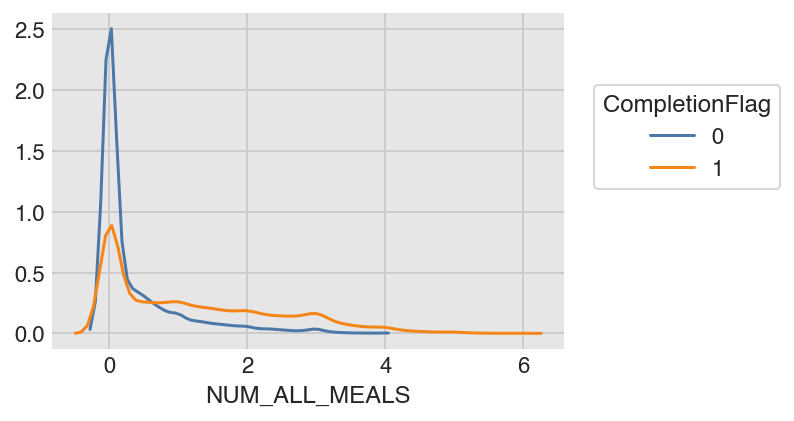

In [138]:
dxp.kde(x='NUM_ALL_MEALS', data=New_df_W_AU_combined.dropna(), split='CompletionFlag', split_order=[0,1])

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arrays/categorical.py:2487: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  res = method(*args, **kwargs)


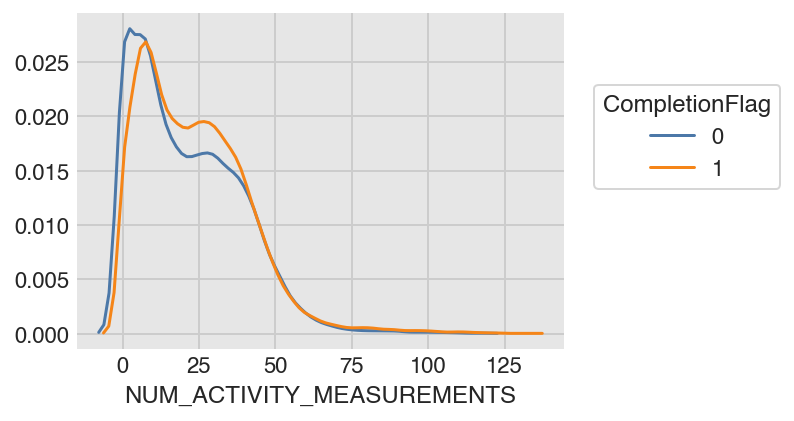

In [139]:


dxp.kde(x='NUM_ACTIVITY_MEASUREMENTS', data=New_df_W_AU_combined.dropna(), split='CompletionFlag', split_order=[0,1])

# Predict <ins>Total Activity Measurent Change (Delta_TAM) 
**goal** to explain features and Delta_TAM relationship

### Linear Regression Model 

#### define X, y

In [178]:
df_W_avg=df_W_avg.dropna()
X=df_W_avg[['NUM_CONVOS', 'TOTAL_ACTIVITY_MINUTES2', 'NUM_ALL_MEALS', 'NUM_ACTIVITY_MEASUREMENTS', 'NUM_WEIGHTS', 'NUM_NOTIFS']]
y=df_W_avg[['Delta_TAM']]

#### remove outliers

In [179]:
upperbound=df_W_avg[['Delta_TAM']].quantile(0.999) # upper bound is 207
y.loc[(y['Delta_TAM']>207),'Delta_TAM'] = 207 


/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1637: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)
/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:692: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value, self.name)


#### build linear model

In [198]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.decomposition import PCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline, FeatureUnion



X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=101)

pcr = Pipeline(steps=[('scale', StandardScaler()), 
                # features are orthognal already, no need for pca
                #      ('pca', PCA(n_components=1)),
                      ('lr', LinearRegression())
                     ])
pcr.fit(X_train, y_train)
# pca = pcr.named_steps['pca']  # retrieve the PCA step of the pipeline

# pls = PLSRegression(n_components=1)
# pls.fit(X_train, y_train)


Pipeline(steps=[('scale', StandardScaler()), ('lr', LinearRegression())])

In [181]:
y_pred = pcr.predict(X_train)
y_test_pred = pcr.predict( X_test)

<AxesSubplot:xlabel='feature', ylabel='coef'>

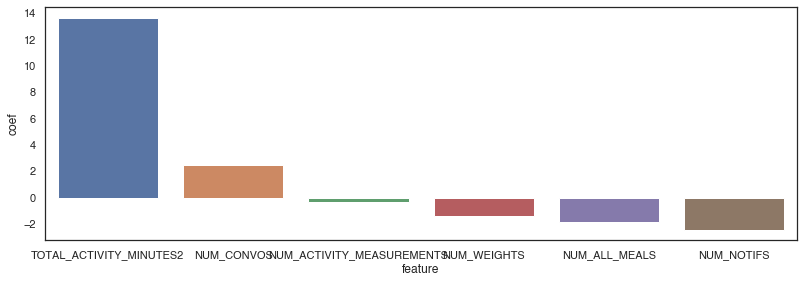

In [230]:
coefficients = pd.concat([pd.DataFrame(X_train.columns),pd.DataFrame(np.transpose(pcr['lr'].coef_))], axis = 1)
coefficients.columns=['feature', 'coef']
coefficients=coefficients.sort_values(by=['coef'], ascending=False)
fig = plt.figure(figsize=(12,4))
sns.barplot(x='feature', y='coef', data=coefficients)

**Note** Increase number of activity minutes and conversation will increase the activity time change rate, which make sense

Text(0, 0.5, 'Predicted Delta_Total_Activity_Min')

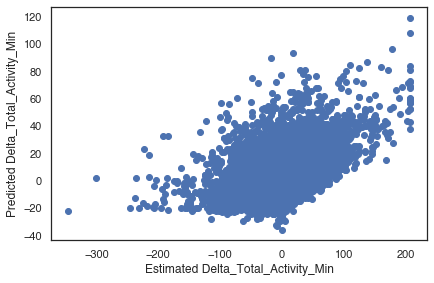

In [182]:
plt.scatter(y_test,y_test_pred)
plt.xlabel('Estimated Delta_Total_Activity_Min')
plt.ylabel('Predicted Delta_Total_Activity_Min')

### underfitting, let's try to improve use randomforest

In [183]:
# calculate these metrics by hand!
from sklearn import metrics
from sklearn.metrics import r2_score
print('training set')
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('r2_score', r2_score(y_train, y_pred))


print('test set')
print('MAE:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
print('r2_score', r2_score(y_test,y_test_pred))

training set
MAE: 22.564718927171032
MSE: 1066.7951841800416
RMSE: 32.661830692415904
r2_score 0.15473605571915972
test set
MAE: 22.36565065128975
MSE: 1030.7726035311216
RMSE: 32.10564753327865
r2_score 0.1604624783785309


/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


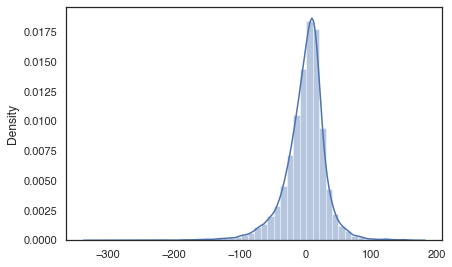

In [184]:
sns.distplot((y_test-y_test_pred),bins=50);

# RandomForrest Modeling

In [214]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression

In [215]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 50, stop = 200, num = 3)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(50, 100, num = 3)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [5]
# Minimum number of samples required at each leaf node
min_samples_leaf = [2]
# Method of selecting samples for training each tree
bootstrap = [True]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

print(random_grid)

{'n_estimators': [50, 125, 200], 'max_features': ['auto', 'sqrt'], 'max_depth': [50, 75, 100, None], 'min_samples_split': [5], 'min_samples_leaf': [2], 'bootstrap': [True]}


In [216]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestRegressor(random_state = 42)
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid,
                              n_iter = 100, scoring='neg_mean_absolute_error', 
                              cv = 2, verbose=2, random_state=42, n_jobs=-1,
                              return_train_score=True)

In [217]:
%%time

rf_gs_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('rf', rf_random)
#     ('gs', rf_gs)
])

rf_gs_pipeline.fit(X_train, y_train)



Fitting 2 folds for each of 24 candidates, totalling 48 fits


/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:285: UserWarning: The total space of parameters 24 is smaller than n_iter=100. Running 24 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(
/opt/anaconda3/lib/python3.8/site-packages/sklearn/model_selection/_search.py:880: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


CPU times: user 13.1 s, sys: 343 ms, total: 13.4 s
Wall time: 1min 45s


Pipeline(steps=[('scaler', RobustScaler()),
                ('rf',
                 RandomizedSearchCV(cv=2,
                                    estimator=RandomForestRegressor(random_state=42),
                                    n_iter=100, n_jobs=-1,
                                    param_distributions={'bootstrap': [True],
                                                         'max_depth': [50, 75,
                                                                       100,
                                                                       None],
                                                         'max_features': ['auto',
                                                                          'sqrt'],
                                                         'min_samples_leaf': [2],
                                                         'min_samples_split': [5],
                                                         'n_estimators': [50,
                           

In [218]:
best_params = rf_gs_pipeline[1].best_params_
best_params

{'n_estimators': 200,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 'sqrt',
 'max_depth': 75,
 'bootstrap': True}

In [219]:
# Instantiate random forest and train on tuned parameters
rf_exp = RandomForestRegressor(n_estimators=200,
                                 min_samples_split= 5,
                                 min_samples_leaf= 2,
                                 max_features='sqrt',
                                 max_depth= 50,
                                 bootstrap=True, 
                               random_state=42)

In [220]:
%%time

rf_gs_pipeline = Pipeline([
#     ('prep', preprocessor),
    ('scaler', RobustScaler()),
    ('rf', rf_exp)
#     ('gs', rf_gs)
])
# rf_exp.fit(X_train, y_train);
rf_gs_pipeline.fit(X_train, y_train)

/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:346: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


CPU times: user 12.9 s, sys: 140 ms, total: 13.1 s
Wall time: 13.1 s


Pipeline(steps=[('scaler', RobustScaler()),
                ('rf',
                 RandomForestRegressor(max_depth=50, max_features='sqrt',
                                       min_samples_leaf=2, min_samples_split=5,
                                       n_estimators=200, random_state=42))])

In [221]:
# Make validation on test data
y_train_pred = rf_gs_pipeline.predict(X_train)
y_train_pred

array([-12.29733685, -18.4506546 ,   3.06354304, ...,   3.56727262,
        -6.64653306,   1.60390177])

In [222]:
# Make validation on test data
y_test_pred = rf_gs_pipeline.predict(X_test)
len(y_test_pred)

16125

[0.10726389 0.38700177 0.0904525  0.2375609  0.05434568 0.12337526]


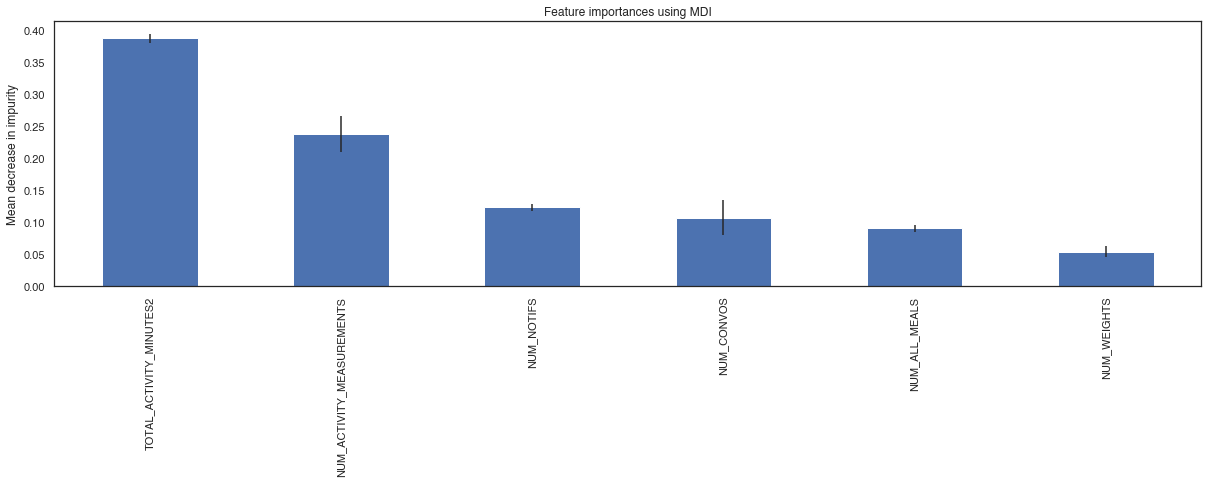

In [223]:
#Create a feature importance plot
importances = rf_gs_pipeline.steps[1][1].feature_importances_
print(importances)
feature_names=X.columns
# model.named_steps["transformer"].get_feature_names()
std = np.std([
    tree.feature_importances_ for tree in rf_gs_pipeline.steps[1][1].estimators_], axis=0)

from sklearn.inspection import permutation_importance
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.sort_values(ascending=False).plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()
fig.set_size_inches(18.5, 15)

Text(0, 0.5, 'Predicted TAM')

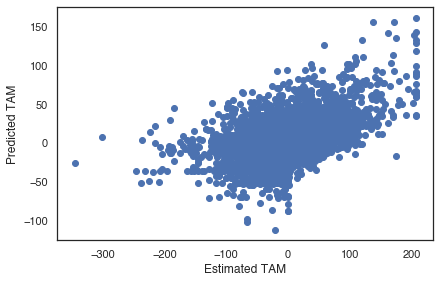

In [224]:
plt.scatter(y_test,y_test_pred)
plt.xlabel('Estimated TAM')
plt.ylabel('Predicted TAM')

In [225]:
print('training set')
print('MAE:', metrics.mean_absolute_error(y_train, y_pred))
print('MSE:', metrics.mean_squared_error(y_train, y_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_train, y_pred)))
print('r2_score', r2_score(y_train, y_pred))


print('test set')
print('MAE:', metrics.mean_absolute_error(y_test,y_test_pred))
print('MSE:', metrics.mean_squared_error(y_test,y_test_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test,y_test_pred)))
print('r2_score', r2_score(y_test,y_test_pred))

training set
MAE: 22.564718927171032
MSE: 1066.7951841800416
RMSE: 32.661830692415904
r2_score 0.15473605571915972
test set
MAE: 22.014715565896783
MSE: 1001.8366005652967
RMSE: 31.651802485250293
r2_score 0.1840301014724509


### Conclusion of RF  
1. instead of getting a perfect fit, the goal is to explain the relationship between features and targets 
2. RF has slightly better fit than linear regression.